In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

In [91]:
from __future__ import absolute_import, print_function
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

In [1]:
import scipy as sp
from scipy.spatial.distance import mahalanobis

import datetime
from math import pi, ceil

# Visualization
from IPython.display import Image

# Data prepping
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Problem Statements

1.     Predict song’s popularity based on song’s audio features.

2.     Design a personalized song recommender system based on song’s audio features.

Spotify dataset was provided to us by the instructors of this course.

Dataset consisted of 28 music files: one for each year starting from 1991 to 2018. We merged all these files in excel to create one single music file, which we named as “MergedMusic”. We imported this data in our code with the name as “Music”.

In [9]:
music=pd.read_csv('MergedMusic.csv',encoding='latin-1')

### Exploratory Data Analysis

It can be seen from the below distribution that not all the features are normally distributed. Hence, we scaled the features before applying machine learning algorithms.

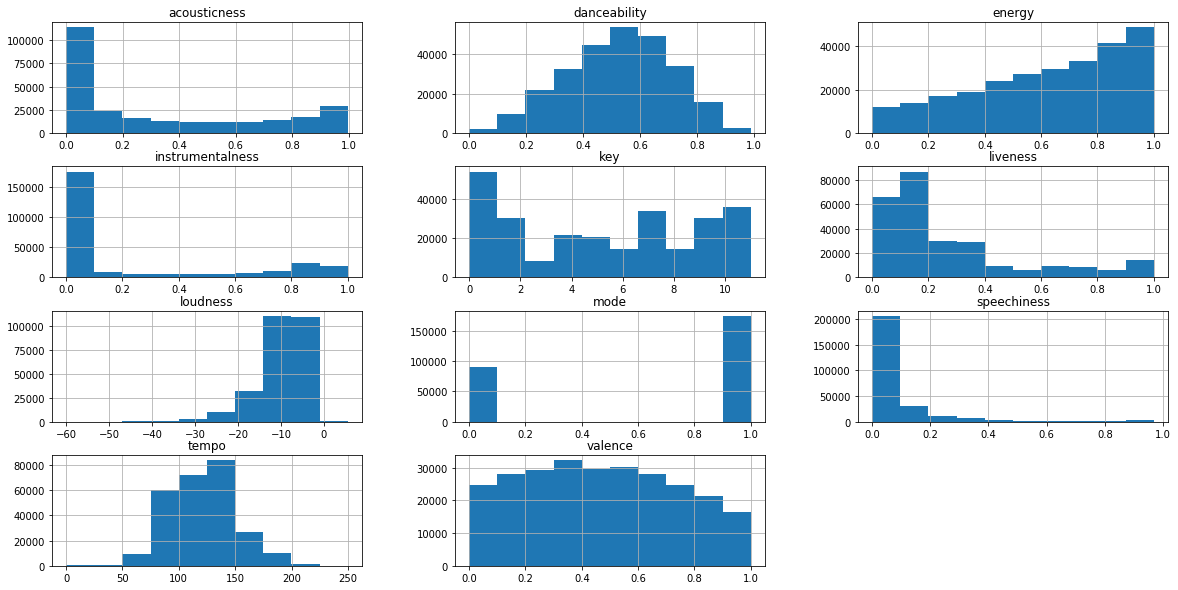

In [10]:
features = ['acousticness','danceability','energy','instrumentalness','key','liveness','loudness','mode',     
                    'speechiness','tempo','valence']
df_features = music[features]
df_features.hist(figsize=(20,10))
plt.show()

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


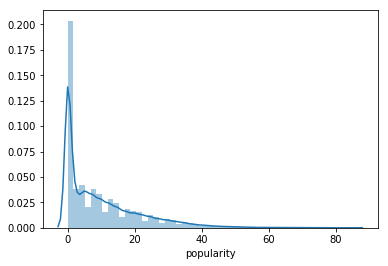

In [3]:
#Target variable distribution
sns.distplot(music['popularity'])

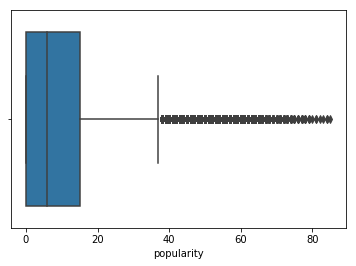

In [24]:
sns.boxplot(music['popularity'])

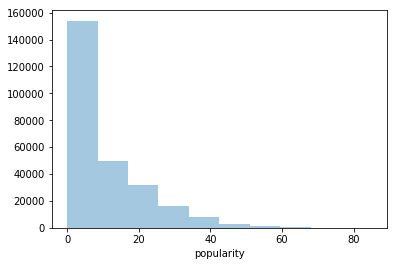

In [34]:
sns.distplot(music['popularity'],bins=10,kde=False)

In [26]:
music['popularity'].describe()


count    265119.000000
mean          9.819802
std          11.452128
min           0.000000
25%           0.000000
50%           6.000000
75%          15.000000
max          85.000000
Name: popularity, dtype: float64

In [4]:
music_features = pd.DataFrame(music[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']])

In [6]:
music_features.to_csv('music_features',index=False)

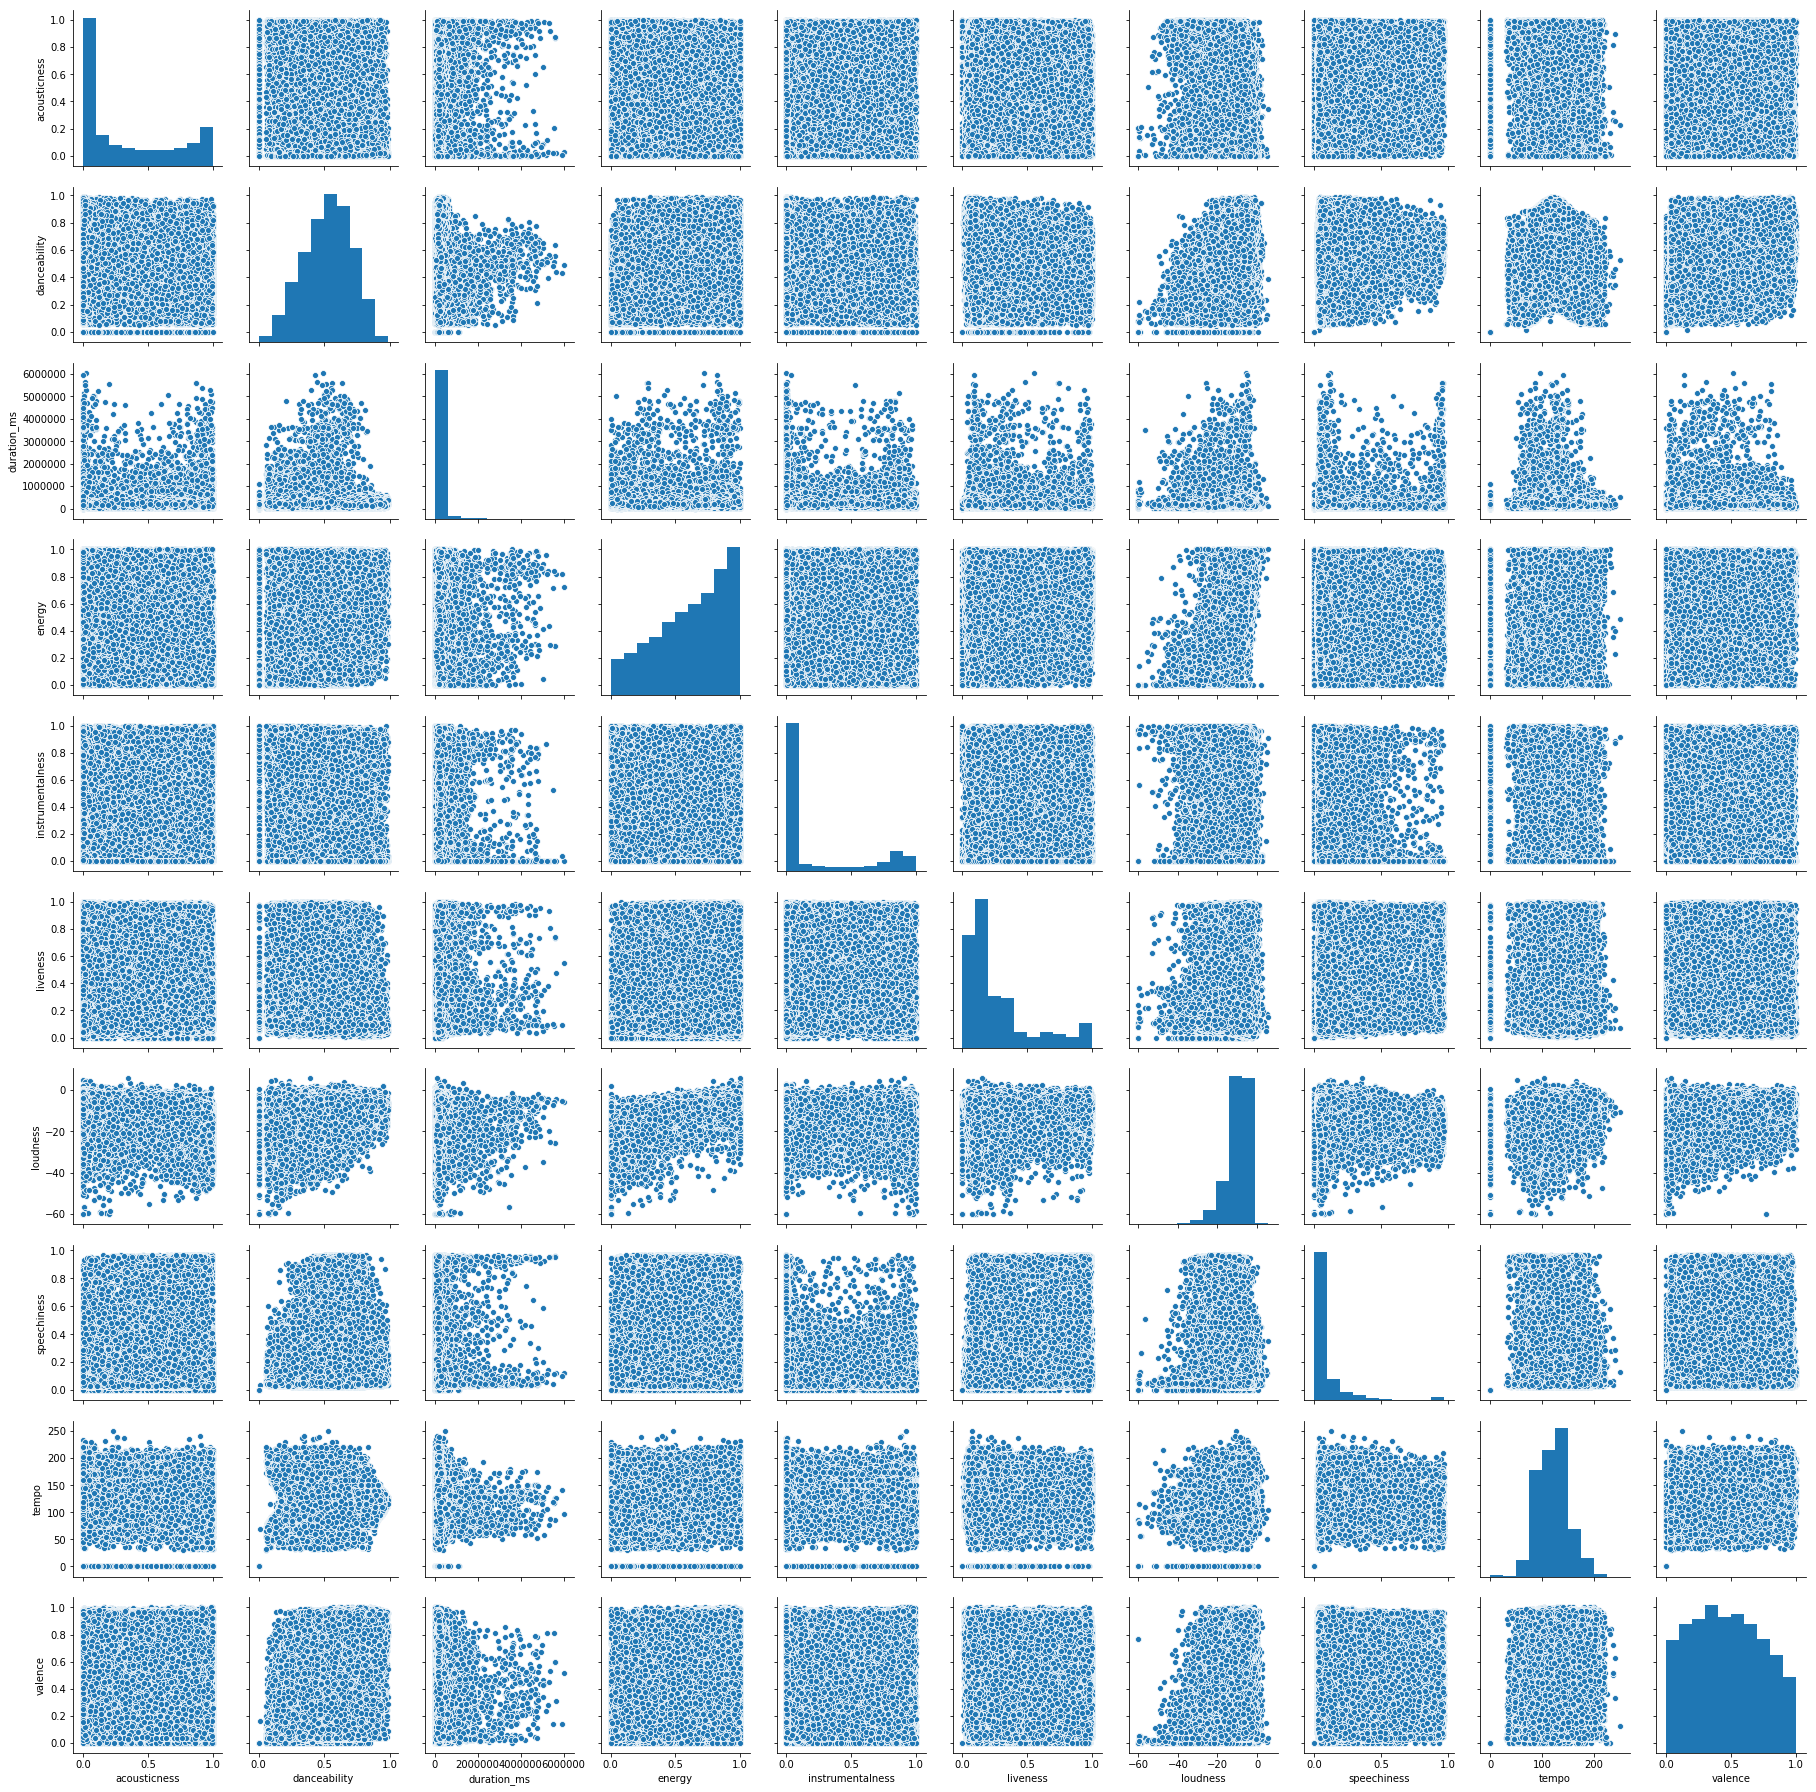

In [43]:
sns.pairplot(music_features)

In [6]:
music_features.corr()

acousticness  danceability  duration_ms    energy  \
acousticness          1.000000     -0.230750    -0.003360 -0.730268   
danceability         -0.230750      1.000000    -0.053007  0.199743   
duration_ms          -0.003360     -0.053007     1.000000 -0.020909   
energy               -0.730268      0.199743    -0.020909  1.000000   
instrumentalness      0.037345     -0.092349     0.111998 -0.094256   
liveness             -0.014427     -0.181350     0.051664  0.170016   
loudness             -0.570452      0.264774    -0.075442  0.770289   
speechiness           0.081569      0.133962     0.003850  0.043285   
tempo                -0.249926      0.022483    -0.013118  0.279500   
valence              -0.195764      0.505019    -0.140956  0.314748   

                  instrumentalness  liveness  loudness  speechiness     tempo  \
acousticness              0.037345 -0.014427 -0.570452     0.081569 -0.249926   
danceability             -0.092349 -0.181350  0.264774     0.133962  0.022483   
duration_ms               0.111998  0.051664 -0.075442     0.003850 -0.013118   
energy                   -0.094256  0.170016  0.770289     0.043285  0.279500   
instrumentalness          1.000000 -0.139052 -0.267702    -0.142203  0.009772   
liveness                 -0.139052  1.000000  0.069377     0.208183 -0.004199   
loudness                 -0.267702  0.069377  1.000000    -0.075128  0.240505   
speechiness              -0.142203  0.208183 -0.075128     1.000000 -0.055155   
tempo                     0.009772 -0.004199  0.240505    -0.055155  1.000000   
valence                  -0.252378 -0.056420  0.326633     0.028844  0.128207   

                   valence  
acousticness     -0.195764  
danceability      0.505019  
duration_ms      -0.140956  
energy            0.314748  
instrumentalness -0.252378  
liveness         -0.056420  
loudness          0.326633  
speechiness       0.028844  
tempo             0.128207  
valence           1.000000

In [7]:
music.shape

(265119, 25)

# Part I - Supervised Learning (Predicting Song Popularity)

For the first objective of our project, which was to predict the popularity of a song based on its audio features, we used the music data. 

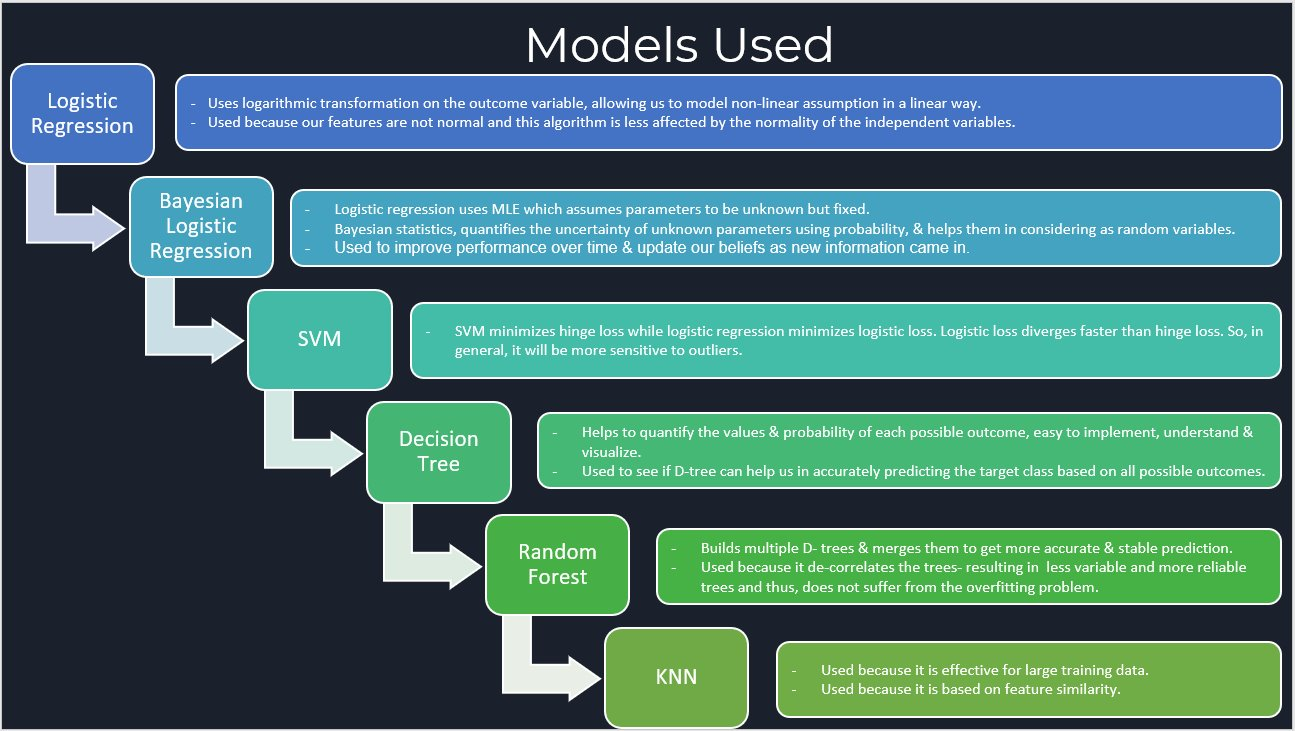

In [87]:
Image(filename='Part_1_Approach.PNG')

The popularity column (target variable) had values ranging from 0 to 100. It had mean of 9.8. To make it a classification problem, we created two categories for this column based on the mean. For all the values in this column which were 10 or above (above the mean), they were labeled as 1 (“Hit”) whereas the rest were labeled as 0 (“Flop”). So, based on Popularity column, we created a new column in our data, named as PopularityCategory, which had two possible classes: 0 and 1 (Flop and Hit).

In [95]:
#Popularity category column added (>=10 -> Hit  and <10 : Flop)
def inputPopularity(cols):
    if cols>=10:
        return 1    
    else:
        return 0
    
music['popularityCategory'] = music['popularity'].apply(inputPopularity)


In [96]:
music_features = pd.DataFrame(music[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularityCategory']])

Next we had to standardized our data. This was done because different columns of our data corresponded to different units. In this case to compare, we had to remove the units. To do this in a consistent way, we standardized and transformed the data to have a common scale before building machine learning models.

In [125]:
#Standard Scaler
from sklearn.preprocessing import StandardScaler

In [126]:
scaler = StandardScaler()
scaler.fit(music_features)

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [128]:
scaled_data = scaler.transform(music_features)

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [138]:
scaled_data1=scaled_data[:,[0,1,2,3,4,5,6,7,8,9]]

In [100]:
new_music_col_names=music_features.columns[0:10]

The new_music_data dataframe had the scaled features along with our target variable, named as “popularity”. We used this dataframe to apply all the models which we will discuss shortly.

In [101]:
new_music_data=pd.DataFrame(scaled_data1,columns=new_music_col_names)

In [102]:
new_music_data['popularity']=music['popularityCategory']
new_music_data.head()

acousticness  danceability  duration_ms    energy  instrumentalness  \
0     -0.640917      0.416856    -0.725090 -0.249212         -0.656476   
1      0.259639      0.465837    -0.253613 -0.201501         -0.653762   
2     -0.814779      1.151574    -0.267618  0.660966          1.869850   
3      1.745416     -1.009041    -0.155830 -1.306192          1.662168   
4      0.842018      0.335221     0.143569 -0.469416         -0.656476   

   liveness  loudness  speechiness     tempo   valence  popularity  
0 -0.872538  0.088139    -0.460135  0.332141  1.869840           1  
1  2.369305 -0.335212    -0.483075  0.150850  0.628472           1  
2 -0.661591  0.137610    -0.449012  0.820039  1.451065           1  
3 -0.720797  0.418954    -0.490722 -0.345276 -1.436985           1  
4 -0.194997  0.260398    -0.482380  0.370505 -0.975585           1

We divided the data into test and training datasets. We took 25% of our data as test dataset. These test and train split will be used for all the models which we have applied. 

In [106]:
from sklearn.model_selection import train_test_split

In [39]:
#spliting the above X and Y data into test data and training data (75% for model training and 25% for model testing)
X_train, X_test, y_train, y_test = train_test_split(new_music_data.drop('popularity',axis=1), 
                                                    new_music_data['popularity'], test_size=0.25, 
                                                    random_state=500)

## Models Used

We had applied the following machine learning algorithms:
-Logistic Regression
-Bayesian Logistic Regression
-SVM
-Decision Tree
-Random Forest
-KNN

Along with running the basic model/algorithm on our data, we tuned most of the models using GridSearchCV and RandomizedSearchCV.

The score/metric which we tried to maximize is the Accuracy score which is the mean accuracy that the predicted label is same as the true label for a given song.

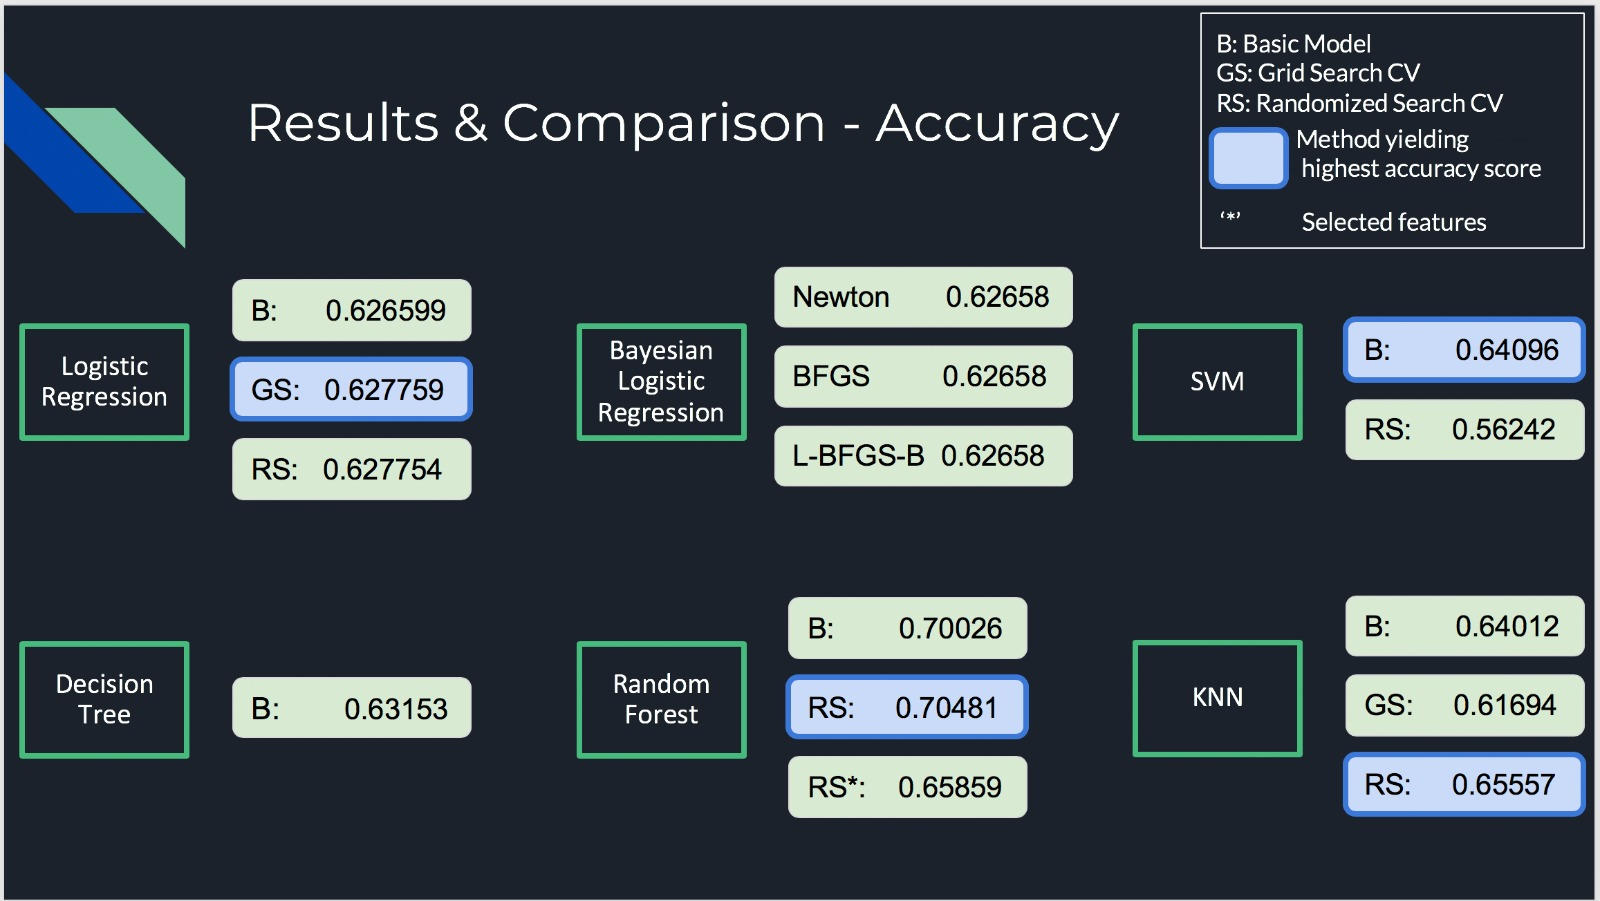

In [89]:
Image(filename='Result_Part_1.jpeg')

### Logistic Regression

Logistic regression uses logarithmic transformation on the outcome variable, allowing us to model non-linear assumption in a linear way. Although a simple model, yet it is very powerful and is generally the starting model used in a binary classification problem. We used this model because because our features are not normal and this algorithm is less affected by the normality of the independent variables.

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
predictions = logmodel.predict(X_test)

In [107]:
from sklearn.metrics import classification_report,confusion_matrix

In [44]:
confusion_matrix(y_test, predictions)

array([[36891,  3412],
       [21337,  4640]], dtype=int64)

In [45]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.63      0.92      0.75     40303
           1       0.58      0.18      0.27     25977

   micro avg       0.63      0.63      0.63     66280
   macro avg       0.60      0.55      0.51     66280
weighted avg       0.61      0.63      0.56     66280



In [46]:
#Accuracy score of logistic regression (mean accuracy which is same as best score)
logmodel.score(X_test,y_test)

0.6265992757996379

The basic logistic model gave us the accuracy score of 0.6265992757996379. To further improve it, we did GridSearchCV (without specifying c), GridSearchCV (with specifying values for c) and RandomizedSearchCV.

In [47]:
from sklearn.model_selection import GridSearchCV

#### Grid Search CV

In [48]:
#Random Search without specifying c
dual=[True,False]
max_iter=[100,110,120,130,140]
param_grid = dict(dual=dual,max_iter=max_iter)

In [49]:
## Didnt work out well
import time

lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 3, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best: 0.627769 using {'dual': True, 'max_iter': 130}
Execution time: 96.14246344566345 ms


D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [47]:
#Random Search with specifying c (results are not better than original model. Also execution time has increased)
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [1.0,1.5,2.0,2.5]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)

In [48]:
#did not improve the accuracy
lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 3, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best: 0.627794 using {'C': 2.0, 'dual': True, 'max_iter': 110}
Execution time: 218.7317831516266 ms


D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Randomized Search CV

In [26]:
from sklearn.model_selection import RandomizedSearchCV

In [50]:
##didnt do anything
#Accuracy doesn't improve. But execution time is less than grid search.
random = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, cv = 3, n_jobs=-1)

start_time = time.time()
random_result = random.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best: 0.627754 using {'max_iter': 110, 'dual': False, 'C': 2.5}
Execution time: 45.89572024345398 ms


All these three models, ran to tune the original model, improved the accuracy score slightly. However, GridSearchCV (with c specified) was computationally expensive (took a lot of time). Based on the results, we concluded that GridSearchCV (without specifying c) gave us the highest accuracy result, i.e. 0.627759141818255.

In [50]:
Best_Accuracy_Logistic = grid_result.best_score_
Best_Accuracy_Logistic

0.6277692002072028

### Bayesian Logistic Regression

####Source: https://github.com/Valassis-Digital-Media/bayes_logistic/blob/master/notebooks/bayeslogistic_demo.ipynb

Bayesian logistic regression using a Laplace (Gaussian) approximation for the posterior distribution of the fitted parameters. As such, it is much faster than using MCMC. It requires numpy and scipy to work.

Briefly, Bayesian logistic regression works by defining a Gaussian prior on the parameter vector $w$ such that $p(w) = \mathcal{N}(w_0, \Sigma_0)$. Crucially, $w_0 \ne 0$ necessarily (non-zero mean) and $\Sigma_0$ is an arbitrary covariance matrix. Note that if $w_0 =0$ and $\Sigma_0$ was diagonal with identical values, then the problem would reduce to L2 regularized logistic regression.

Inclusion of this prior imposes a penalization upon the log likelihood of any data $\mathcal{D}$ we observe. One then has to minimize the negative log posterior which is equal to the following objective up to a constant.

$ f(w|\mathcal{D}) = - \sum_{i=1}^N \{ y_i \log(p_i) + (1-y_i)\log(1-p_i) \}   + \frac{1}{2}(w - w_0)^T \Sigma_0^{-1} (w -w_0)$

where $p_i = e^{X w} /(1 + e^{Xw})$ is the standard logistic probability. This can be minimized by any gradient (Hessian) based solver. Here we use scipy.optimize.minimize

Under the Laplace approximation, the posterior to the parameter vector $w$ is given by a normal distribution $\mathcal{N}(w, H^{-1})$ where $H = \nabla_w^2 f(w|\mathcal{D}) |_{\hat w}$ is the Hessian of the negative penalized log likelihood (log posterior).

$H$ is the same Hessian function that would be used for a Hessian based optimization (such as Newton-CG) of $f(w|\mathcal{D})$. Even if we use a gradent based optimization (such as BFGS) we still need to compute the Hessian to evaluate the posterior distribution. Of course one can use a diagonal approximation to the Hessian (and we allow for this) if there are a large number of parameters.

Using the full (Laplace) posterior of $w$, one can calculate the full posterior predictive e.g. the the probability $p(y|x,\mathcal{D})$ which is a moderated (relaxed towards 0.5) version of $p_i$ (the standard logistic probability). This takes into account the uncertainty in our estimate of $w$.

After logistic regression, we used bayesian logistic regression. Logistic regression uses MLE which assumes parameters to be unknown but fixed. Whereas, Bayesian statistics quantifies the uncertainty of unknown parameters using probability, & helps them in considering as random variables. We Used bayesian logistic regression to improve performance over time & update our beliefs as new information came in but still gave the information we've already learned in the past

In [103]:
y=new_music_data.values[:, 10] 
X = np.delete(new_music_data.values, 10, 1)
n_samples, n_features = X.shape

# Add bias column to the feature matrix
B = np.ones((n_samples, n_features + 1)) 
B[:, 1:] = X 
X = B

In [104]:
def logistic_prob(X, w):
    """ MAP (Bayes point) logistic regression probability with overflow prevention via exponent truncation
    Parameters
    ----------
    X : array-like, shape (N, p)
        Feature matrix
    w : array-like, shape (p, )
        Parameter vector
    Returns
    -------
    pr : array-like, shape (N, )
        vector of logistic regression probabilities
    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)
    """

    # set a truncation exponent.
    trunc = 8.  # exp(8)/(1+exp(8)) = 0.9997 which is close enough to 1 as to not matter in most cases.

    # calculate argument of logit
    z = np.dot(X, w)
    
    # truncate to avoid numerical over/underflow
    z = np.clip(z, -trunc, trunc)
    #print('z',z)
    # calculate logitstic probability
    pr = np.exp(z)
    pr = pr / (1. + pr)
    #print('pr',pr)
    return pr


def f_log_posterior(w, wprior, H, y, X, weights=None):
    """Returns negative log posterior probability.
    Parameters
    ----------
    w : array-like, shape (p, )
        vector of parameters at which the negative log posterior is to be evaluated
    wprior : array-like, shape (p, )
        vector of prior means on the parameters to be fit
    H : array-like, shape (p, p) or (p, )
        Array of prior Hessian (inverse covariance of prior distribution of parameters)
    y : array-like, shape (N, )
        vector of binary ({0,1} responses)
    X : array-like, shape (N, p)
        array of features
    weights : array-like, shape (N, )
        vector of data point weights. Should be within [0,1]
    Returns
    -------
    neg_log_post : float
                negative log posterior probability
    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)
    """

    # fill in weights if need be
    if weights is None:
        weights = np.ones(len(np.atleast_1d(y)), )
    if len(np.atleast_1d(weights)) != len(np.atleast_1d(y)):
        raise ValueError(' weight vector must be same length as response vector')

    # calculate negative log posterior

    eps = 1e-6  # this defined to ensure that we never take a log of zero

    mu = logistic_prob(X, w)

    if len(H.shape) == 2:
        neg_log_post = (- (np.dot(y.T, weights * np.log(mu + eps))
                           + np.dot((1. - y).T, weights * np.log(1. - mu + eps)))
                        + 0.5 * np.dot((w - wprior).T, np.dot(H, (w - wprior))))
    elif len(H.shape) == 1:
        neg_log_post = (- (np.dot(y.T, weights * np.log(mu + eps))
                           + np.dot((1. - y).T, weights * np.log(1. - mu + eps)))
                        + 0.5 * np.dot((w - wprior).T, H * (w - wprior)))
    else:
        raise ValueError('Incompatible Hessian')
    #print('neg_log_post',neg_log_post)
    return float(neg_log_post)


def g_log_posterior(w, wprior, H, y, X, weights=None):
    """Returns gradient of the negative log posterior probability.
    Parameters
    ----------
    w : array-like, shape (p, )
        parameter vector at which the gradient is to be evaluated
    wprior : array-like, shape (p, )
        array of prior means on the parameters to be fit
    H : array-like, shape (p, p) or (p, )
        array of prior Hessian (inverse covariance of prior distribution of parameters)
    y : array-like, shape (N, )
        array of binary ({0,1} responses)
    X : array-like, shape (N, p)
        array of features
    weights : array-like, shape (N, )
        array of data point weights. Should be within [0,1]
    Returns
    -------
    grad_log_post : array-like, shape (p, )
                gradient of negative log posterior
    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)
    """

    # fill in weights if need be
    if weights is None:
        weights = np.ones(len(np.atleast_1d(y)), )
    if len(np.atleast_1d(weights)) != len(np.atleast_1d(y)):
        raise ValueError(' weight vector must be same length as response vector')

    # calculate gradient

    mu_ = logistic_prob(X, w)

    if len(H.shape) == 2:
        grad_log_post = np.dot(X.T, weights * (mu_ - y)) + np.dot(H, (w - wprior))
    elif len(H.shape) == 1:
        grad_log_post = np.dot(X.T, weights * (mu_ - y)) + H * (w - wprior)
    else:
        raise ValueError('Incompatible Hessian')
    #print('grad_log_post',grad_log_post)
    return grad_log_post


def g_log_posterior_small(w, wprior, H, y, X, weights=None):
    """Returns normalized (to 1) gradient of the negative log posterior probability.
    This is used for BFGS and L-BFGS-B solvers which tend to not converge unless
    the gradient is normalized.
    Parameters
    ----------
    w : array-like, shape (p, )
        parameter vector at which the gradient is to be evaluated
    wprior : array-like, shape (p, )
        array of prior means on the parameters to be fit
    H : array-like, shape (p, p) or (p, )
        array of prior Hessian (inverse covariance of prior distribution of parameters)
    y : array-like, shape (N, )
        array of binary ({0,1} responses)
    X : array-like, shape (N, p)
        array of features
    weights : array-like, shape (N, )
        array of data point weights. Should be within [0,1]
    Returns
    -------
    grad_log_post : array-like, shape (p, )
                normalized (to 1) gradient of negative log posterior
    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)
    """

    # fill in weights if need be
    if weights is None:
        weights = np.ones(len(np.atleast_1d(y)), )
    if len(np.atleast_1d(weights)) != len(np.atleast_1d(y)):
        raise ValueError(' weight vector must be same length as response vector')

    # calculate gradient

    mu = logistic_prob(X, w)

    if len(H.shape) == 2:
        grad_log_post = np.dot(X.T, weights * (mu - y)) + np.dot(H, (w - wprior))
    elif len(H.shape) == 1:
        grad_log_post = np.dot(X.T, weights * (mu - y)) + H * (w - wprior)
    else:
        raise ValueError('Incompatible Hessian')

    # normalize gradient to length 1
    grad_log_post = grad_log_post / np.sqrt(np.sum(grad_log_post * grad_log_post))

    return grad_log_post


def H_log_posterior(w, wprior, H, y, X, weights=None):
    """Returns Hessian (either full or diagonal) of the negative log posterior probability.
    Parameters
    ----------
    w : array-like, shape (p, )
        parameter vector at which the Hessian is to be evaluated
    wprior : array-like, shape (p, )
        array of prior means on the parameters to be fit
    H : array-like, shape (p, p) or (p, )
        array of log prior Hessian (inverse covariance of prior distribution of parameters)
    y : array-like, shape (N, )
        array of binary ({0,1} responses)
    X : array-like, shape (N, p)
        array of features
    weights : array-like, shape (N, )
        array of data point weights. Should be within [0,1]
    Returns
    -------
    H_log_post : array-like, shape like `H`
                Hessian of negative log posterior
    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)
    """

    # fill in weights if need be
    if weights is None:
        weights = np.ones(len(np.atleast_1d(y)), )
    if len(np.atleast_1d(weights)) != len(np.atleast_1d(y)):
        raise ValueError(' weight vector must be same length as response vector')

    # calculate log posterior Hessian

    mu = logistic_prob(X, w)

    S = mu * (1. - mu) * weights

    if len(H.shape) == 2:
        H_log_post = np.dot(X.T, X * S[:, np.newaxis]) + H
    elif len(H.shape) == 1:
        H_log_post = np.diag(np.dot(X.T, X * S[:, np.newaxis])) + H
    else:
        raise ValueError('Incompatible Hessian')

    return H_log_post


def HP_log_posterior(w, q, wprior, H, y, X, weights=None):
    """Returns diagonal Hessian of the negative log posterior probability multiplied by an arbitrary vector.
    This is useful for the Newton-CG solver, particularly when we only want to store a diagonal Hessian.
    Parameters
    ----------
    w : array-like, shape (p, )
        parameter vector at which the Hessian is to be evaluated
    q : array-like, shape (p, )
        arbitrary vector to multiply Hessian by
    wprior : array-like, shape (p, )
        array of prior means on the parameters to be fit
    H : array-like, shape (p, )
        array of diagonal log prior Hessian (inverse covariance of prior distribution of parameters)
    y : array-like, shape (N, )
        array of binary ({0,1} responses)
    X : array-like, shape (N, p)
        array of features
    weights : array-like, shape (N, )
        array of data point weights. Should be within [0,1]
    Returns
    -------
    HP : array-like, shape (p, )
        Hessian of log posterior (diagonal approx) multiplied by arbitrary vector
    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)
    """

    # fill in weights if need be
    if weights is None:
        weights = np.ones(len(np.atleast_1d(y)), )
    if len(np.atleast_1d(weights)) != len(np.atleast_1d(y)):
        raise ValueError(' weight vector must be same length as response vector')

    HP = H_log_posterior(w, wprior, H, y, X, weights)
    HP = HP * q

    return HP


def fit_bayes_logistic(y, X, wprior, H, weights=None, solver='Newton-CG', bounds=None, maxiter=100):
    """ Bayesian Logistic Regression Solver.  Assumes Laplace (Gaussian) Approximation
    to the posterior of the fitted parameter vector. Uses scipy.optimize.minimize
    Parameters
    ----------
    y : array-like, shape (N, )
        array of binary {0,1} responses
    X : array-like, shape (N, p)
        array of features
    wprior : array-like, shape (p, )
        array of prior means on the parameters to be fit
    H : array-like, shape (p, p) or (p, )
        array of prior Hessian (inverse covariance of prior distribution of parameters)
    weights : array-like, shape (N, )
        array of data point weights. Should be within [0,1]
    solver : string
        scipy optimize solver used.  this should be either 'Newton-CG', 'BFGS' or 'L-BFGS-B'.
        The default is Newton-CG.
    bounds : iterable of length p
        a length p list (or tuple) of tuples each of length 2.
        This is only used if the solver is set to 'L-BFGS-B'. In that case, a tuple
        (lower_bound, upper_bound), both floats, is defined for each parameter.  See the
        scipy.optimize.minimize docs for further information.
    maxiter : int
        maximum number of iterations for scipy.optimize.minimize solver.
    Returns
    -------
    w_fit : array-like, shape (p, )
        posterior parameters (MAP estimate)
    H_fit : array-like, shape like `H`
        posterior Hessian  (Hessian of negative log posterior evaluated at MAP parameters)
    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)
    """

    # Check that dimensionality of inputs agrees

    # check X
    if len(X.shape) != 2:
        raise ValueError('X must be a N*p matrix')
    (nX, pX) = X.shape

    # check y
    if len(y.shape) > 1:
        raise ValueError('y must be a vector of shape (p, )')
    if len(np.atleast_1d(y)) != nX:
        raise ValueError('y and X do not have the same number of rows')

    # check wprior
    if len(wprior.shape) > 1:
        raise ValueError('prior should be a vector of shape (p, )')
    if len(np.atleast_1d(wprior)) != pX:
        raise ValueError('prior mean has incompatible length')

    # check H
    if len(H.shape) == 1:
        if np.atleast_1d(H).shape[0] != pX:
            raise ValueError('prior Hessian is diagonal but has incompatible length')
    elif len(H.shape) == 2:
        (h1,h2) = np.atleast_2d(H).shape
        if h1 != h2:
            raise ValueError('prior Hessian must either be a p*p square matrix or a vector or shape (p, ) ')
        if h1 != pX:
            raise ValueError('prior Hessian is square but has incompatible size')

    # fill in weights if need be
    if weights is None:
        weights = np.ones(len(np.atleast_1d(y)), )
    if len(np.atleast_1d(weights)) != len(np.atleast_1d(y)):
        raise ValueError(' weight vector must be same length as response vector')

    # Do the regression

    if solver == 'Newton-CG':

        if len(H.shape) == 2:

            ww = minimize(f_log_posterior, wprior, args=(wprior, H, y, X, weights), jac=g_log_posterior,
                          hess=H_log_posterior, method='Newton-CG', options={'maxiter': maxiter})
            w_fit = ww.x
            H_fit = H_log_posterior(w_fit, wprior, H, y, X, weights)

        elif len(H.shape) == 1:

            ww = minimize(f_log_posterior, wprior, args=(wprior, H, y, X, weights), jac=g_log_posterior,
                          hessp=HP_log_posterior, method='Newton-CG', options={'maxiter': maxiter})
            w_fit = ww.x
            H_fit = H_log_posterior(w_fit, wprior, H, y, X, weights)

        else:
            raise ValueError(' You must either use the full Hessian or its diagonal as a vector')

    elif solver == 'BFGS':
        ww = minimize(f_log_posterior, wprior, args=(wprior, H, y, X, weights), jac=g_log_posterior_small,
                      method='BFGS', options={'maxiter': maxiter})
        w_fit = ww.x
        H_fit = H_log_posterior(w_fit, wprior, H, y, X, weights)
       

    elif solver == 'L-BFGS-B':
        ww = minimize(f_log_posterior, wprior, args=(wprior, H, y, X, weights), jac=g_log_posterior_small,
                      method='L-BFGS-B', bounds=bounds, options={'maxiter': maxiter})
        w_fit = ww.x
        H_fit = H_log_posterior(w_fit, wprior, H, y, X, weights)

    else:
        raise ValueError('Unknown solver specified: "{0}"'.format(solver))
    
    print("Sampled w:", ww.x)
    #print(ww.shape)
    return w_fit, H_fit



def bayes_logistic_prob(X, w, H):
    """ Posterior predictive logistic regression probability.  Uses probit approximation
        to the logistic regression sigmoid. Also has overflow prevention via exponent truncation.
    Parameters
    ----------
    X : array-like, shape (N, p)
        array of covariates
    w : array-like, shape (p, )
        array of fitted MAP parameters
    H : array-like, shape (p, p) or (p, )
        array of log posterior Hessian (covariance matrix of fitted MAP parameters)
    Returns
    -------
    pr : array-like, shape (N, )
        moderated (by full distribution) logistic probability
    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)
    """

    # set a truncation exponent
    trunc = 8.  # exp(8)/(1+exp(8)) = 0.9997 which is close enough to 1 as to not matter in most cases.

    # unmoderated argument of exponent
    z_a = np.dot(X, w)

    # find  the moderation
    if len(H.shape) == 2:
        H_inv_ = np.linalg.inv(H)
        sig2_a = np.sum(X * np.dot(H_inv_, X.T).T, axis=1)
    elif len(H.shape) == 1:
        H_inv_ = 1. / H
        sig2_a = np.sum(X * (H_inv_ * X), axis=1)
    else:
        raise ValueError(' You must either use the full Hessian or its diagonal as a vector')
    print('H inverse',H_inv_)
    print('sig2_a',sig2_a)
    # get the moderation factor. Implicit in here is approximating the logistic sigmoid with
    # a probit by setting the probit and sigmoid slopes to be equal at the origin. This is where
    # the factor of pi/8 comes from.
    kappa_sig2_a = 1. / np.sqrt(1. + 0.125 * np.pi * sig2_a)

    # calculate the moderated argument of the logit
    z = z_a * kappa_sig2_a
    # do a truncation to prevent exp overflow
    z = np.clip(z, -trunc, trunc)

    # get the moderated logistic probability
    pr = np.exp(z)
    pr = pr / (1. + pr)

    return pr

For Bayesian Logistic Regression, we used three solvers: Newton, BFGS,  L-BFGS-B. This train-test split was used for all three solvers. 

In [108]:
# The data is divided into training and test sets

training_X, test_X, training_y, test_y = train_test_split(X,y, test_size=0.25, random_state=500)

#### Solver = Newton

We have used Scipy.optimize.minimize function for Minimization of scalar function of one or more variables using the parameter method = ‘Newton-CG'

In [110]:
# Train the model for Newton CG
w_prior = np.zeros(n_features + 1)
H_prior = np.diag(np.ones(n_features + 1))*0.001

GD_BATCH_SIZE = len(training_X)
ITERATION_CNT = 10
w = training_X.shape[1]
w_prior = np.zeros(w)
H_prior = np.diag(np.ones(w))*0.001

for i in range(0, ITERATION_CNT):
    for idx in range(0, len(training_X), GD_BATCH_SIZE):
        batch_size = GD_BATCH_SIZE if (idx + GD_BATCH_SIZE) < len(training_X) else len(training_X) - idx
        print("batch_size",batch_size)
        print("GD_BATCH_SIZE",GD_BATCH_SIZE)
        w_posterior, H_posterior = fit_bayes_logistic(training_y[idx:batch_size],
                                                     training_X[idx:batch_size,:],
                                                     w_prior, H_prior)
        w_prior = copy.copy(w_posterior)
        H_prior = copy.copy(H_posterior)

w_fit = w_prior
H_fit = H_prior

batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47972246 -0.07678226  0.08296367 -0.02091532 -0.13442198 -0.20943071
  0.16361815  0.39670615 -0.13017971  0.02190441 -0.10010812]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47972266 -0.07678296  0.08296355 -0.02091623 -0.13442248 -0.20943065
  0.16361771  0.39670619 -0.13017965  0.02190392 -0.10010798]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.4797227  -0.07678368  0.08296331 -0.02091642 -0.13442343 -0.20943054
  0.1636177   0.39670644 -0.13017946  0.02190378 -0.10010775]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47972272 -0.07678403  0.08296318 -0.02091652 -0.13442394 -0.20943047
  0.1636177   0.39670663 -0.13017936  0.02190371 -0.10010765]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47972274 -0.07678424  0.08296311 -0.02091658 -0.13442426 -0.20943042
  0.1636177   0.39670677 -0.1301793   0.02190367 -0.10010759]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47972275 -0.07678437 

We have got 10 sampled w.

In [111]:
# Perform Test for Newton CG
test_probs = bayes_logistic_prob(test_X, w_fit, H_fit)

H inverse [[ 2.27398107e-06  5.08070963e-08 -5.93049197e-08  2.52135792e-08
   1.54673489e-07  1.27469153e-07 -6.97858484e-08 -4.13757808e-07
   7.95356329e-08 -2.18179325e-08  3.90948854e-08]
 [ 5.08070963e-08  5.34454306e-06  7.75455696e-07  8.85087961e-08
   4.10153250e-06 -4.25526584e-08 -3.79170828e-07 -2.16477760e-07
  -6.39046346e-07  2.85471351e-07 -6.41418003e-07]
 [-5.93049197e-08  7.75455696e-07  3.49218958e-06 -1.12815689e-07
   9.00275745e-07 -3.29412184e-07  5.92689664e-07 -7.87324757e-07
  -7.31643593e-07  3.17688163e-07 -1.67417710e-06]
 [ 2.52135792e-08  8.85087961e-08 -1.12815689e-07  2.85090586e-06
  -1.30798670e-07 -2.25688122e-07 -1.70377926e-07  2.06405094e-07
   8.47387737e-08  1.25588797e-09  3.53569437e-07]
 [ 1.54673489e-07  4.10153250e-06  9.00275745e-07 -1.30798670e-07
   1.00767432e-05 -1.25527816e-06 -1.07969491e-06 -6.00940563e-06
  -1.30738703e-06 -3.62036679e-07 -1.35558075e-06]
 [ 1.27469153e-07 -4.25526584e-08 -3.29412184e-07 -2.25688122e-07
  -1.2552

In [84]:
df_Newton=pd.DataFrame(test_probs,columns=["y_prob"])
df_Newton["y"]=test_y

In [85]:
def PredictionPopularity(cols):
    if cols>0.5:
        return 1    
    else:
        return 0
    
df_Newton['y_hat'] = df_Newton["y_prob"].apply(PredictionPopularity)


In [86]:
df_Newton.head()

y_prob    y  y_hat
0  0.322417  0.0      0
1  0.310525  1.0      0
2  0.304558  0.0      0
3  0.445800  1.0      0
4  0.459805  0.0      0

In [87]:
print(confusion_matrix(df_Newton["y"],df_Newton["y_hat"]))

[[36890  3413]
 [21337  4640]]


In [88]:
print(classification_report(df_Newton["y"],df_Newton["y_hat"]))

              precision    recall  f1-score   support

         0.0       0.63      0.92      0.75     40303
         1.0       0.58      0.18      0.27     25977

   micro avg       0.63      0.63      0.63     66280
   macro avg       0.60      0.55      0.51     66280
weighted avg       0.61      0.63      0.56     66280



In [112]:
#Mean accuracy from confusion matrix
print("Accuracy:", (36890+4640)/66280)

Accuracy: 0.6265841882920942


#### Solver: BFGS

We have used Scipy.optimize.minimize function for Minimization of scalar function of one or more variables using the parameter method =’BFGS’

In [113]:
#Training the model
w_prior = np.zeros(n_features + 1)
H_prior = np.diag(np.ones(n_features + 1))*0.001

GD_BATCH_SIZE = len(training_X)
ITERATION_CNT = 10
w = training_X.shape[1]
w_prior = np.zeros(w)
H_prior = np.diag(np.ones(w))*0.001

for i in range(0, ITERATION_CNT):
    for idx in range(0, len(training_X), GD_BATCH_SIZE):
        batch_size = GD_BATCH_SIZE if (idx + GD_BATCH_SIZE) < len(training_X) else len(training_X) - idx
        print("batch_size",batch_size)
        print("GD_BATCH_SIZE",GD_BATCH_SIZE)
        w_posterior, H_posterior = fit_bayes_logistic(training_y[idx:batch_size],
                                                     training_X[idx:batch_size,:],
                                                     w_prior, H_prior, solver="BFGS")
        w_prior = copy.copy(w_posterior)
        H_prior = copy.copy(H_posterior)

w_fit_BFGS = w_prior
H_fit_BFGS = H_prior

batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47972275 -0.07678474  0.08296298 -0.02091686 -0.13442512 -0.20943055
  0.16361764  0.39670704 -0.130179    0.02190372 -0.10010773]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47972288 -0.07678494  0.08296301 -0.02091684 -0.13442505 -0.20943019
  0.1636176   0.39670728 -0.13017926  0.02190346 -0.10010741]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47972288 -0.07678494  0.08296301 -0.02091684 -0.13442505 -0.20943019
  0.1636176   0.39670728 -0.13017926  0.02190346 -0.10010741]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47972288 -0.07678494  0.08296301 -0.02091684 -0.13442505 -0.20943019
  0.1636176   0.39670728 -0.13017926  0.02190346 -0.10010741]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47972288 -0.07678494  0.08296301 -0.02091684 -0.13442505 -0.20943019
  0.1636176   0.39670728 -0.13017926  0.02190346 -0.10010741]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47972288 -0.07678494 

We have sampled 10 w. 

In [114]:
# Perform Test for BFGS
test_probs = bayes_logistic_prob(test_X, w_fit_BFGS, H_fit_BFGS)

H inverse [[ 2.27398123e-06  5.08077134e-08 -5.93048338e-08  2.52140428e-08
   1.54674257e-07  1.27469001e-07 -6.97858968e-08 -4.13758420e-07
   7.95356806e-08 -2.18177888e-08  3.90947667e-08]
 [ 5.08077134e-08  5.34454322e-06  7.75455578e-07  8.85088916e-08
   4.10153270e-06 -4.25523875e-08 -3.79170962e-07 -2.16478254e-07
  -6.39046035e-07  2.85471270e-07 -6.41417903e-07]
 [-5.93048338e-08  7.75455578e-07  3.49218956e-06 -1.12816015e-07
   9.00275784e-07 -3.29412097e-07  5.92689654e-07 -7.87324875e-07
  -7.31643584e-07  3.17688070e-07 -1.67417713e-06]
 [ 2.52140428e-08  8.85088916e-08 -1.12816015e-07  2.85091079e-06
  -1.30798854e-07 -2.25688392e-07 -1.70378272e-07  2.06405029e-07
   8.47394006e-08  1.25576932e-09  3.53570036e-07]
 [ 1.54674257e-07  4.10153270e-06  9.00275784e-07 -1.30798854e-07
   1.00767441e-05 -1.25527792e-06 -1.07969508e-06 -6.00940706e-06
  -1.30738674e-06 -3.62036742e-07 -1.35558086e-06]
 [ 1.27469001e-07 -4.25523875e-08 -3.29412097e-07 -2.25688392e-07
  -1.2552

In [93]:
df_BFGS=pd.DataFrame(test_probs,columns=["y_prob"])
df_BFGS["y"]=test_y
df_BFGS['y_hat'] = df_BFGS["y_prob"].apply(PredictionPopularity)

In [94]:
df_BFGS.head()

y_prob    y  y_hat
0  0.322417  0.0      0
1  0.310525  1.0      0
2  0.304557  0.0      0
3  0.445800  1.0      0
4  0.459805  0.0      0

In [95]:
print(confusion_matrix(df_BFGS["y"],df_BFGS["y_hat"]))

[[36890  3413]
 [21337  4640]]


In [96]:
print(classification_report(df_BFGS["y"],df_BFGS["y_hat"]))

              precision    recall  f1-score   support

         0.0       0.63      0.92      0.75     40303
         1.0       0.58      0.18      0.27     25977

   micro avg       0.63      0.63      0.63     66280
   macro avg       0.60      0.55      0.51     66280
weighted avg       0.61      0.63      0.56     66280



In [97]:
#Mean accuracy from confusion matrix
print("Accuracy:", (36890+4640)/66280)

Accuracy: 0.6265841882920942


#### Solver: LBFGSB

We have used Scipy.optimize.minimize function for Minimization of scalar function of one or more variables using the parameter method =’LBFGSB’

In [116]:
# fit via L-BFGS-B so we can impose bounds

# first make a list of tuples with the bounds for each parameter in it 
# (see the scipy.optimize.minimize docs)

bnd = (-0.25,0.25)
bnd_list = [(None,None)]
for _ in np.arange(11-1):
    bnd_list.append(bnd)

In [117]:
# Train the model
w_prior = np.zeros(n_features + 1)
H_prior = np.diag(np.ones(n_features + 1))*0.001

GD_BATCH_SIZE = len(training_X)
ITERATION_CNT = 10
w = training_X.shape[1]
w_prior = np.zeros(w)
H_prior = np.diag(np.ones(w))*0.001

for i in range(0, ITERATION_CNT):
    for idx in range(0, len(training_X), GD_BATCH_SIZE):
        batch_size = GD_BATCH_SIZE if (idx + GD_BATCH_SIZE) < len(training_X) else len(training_X) - idx
        print("batch_size",batch_size)
        print("GD_BATCH_SIZE",GD_BATCH_SIZE)
        w_posterior, H_posterior = fit_bayes_logistic(training_y[idx:batch_size],
                                                     training_X[idx:batch_size,:],
                                                     w_prior, H_prior, solver='L-BFGS-B', bounds = bnd_list)
        w_prior = copy.copy(w_posterior)
        H_prior = copy.copy(H_posterior)

w_fit_LBFGSB = w_prior
H_fit_LBFGSB = H_prior

batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47377793 -0.07287612  0.09709751 -0.02454203 -0.03038977 -0.2379514
  0.1570609   0.25       -0.14939477  0.02466567 -0.10478938]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47377793 -0.07287612  0.09709751 -0.02454203 -0.03038977 -0.2379514
  0.1570609   0.25       -0.14939477  0.02466567 -0.10478938]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47377768 -0.07287617  0.09709738 -0.02454278 -0.03038981 -0.23794997
  0.15706067  0.25       -0.14939653  0.02466624 -0.10478973]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47377755 -0.07287615  0.09709742 -0.02454319 -0.0303898  -0.23794939
  0.15706071  0.25       -0.14939727  0.02466646 -0.10478981]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47377747 -0.07287611  0.09709749 -0.02454349 -0.03038979 -0.23794903
  0.15706078  0.25       -0.14939775  0.02466659 -0.10478985]
batch_size 198840
GD_BATCH_SIZE 198840
Sampled w: [-0.47377747 -0.07287611  0

We have sampled 10 w. 

In [118]:
# Perform Test for LBFGSB
test_probs = bayes_logistic_prob(test_X, w_fit_LBFGSB, H_fit_LBFGSB)

H inverse [[ 2.24798712e-06  4.83542670e-08 -6.53319101e-08  2.87126751e-08
   6.56457488e-08  1.51766054e-07 -6.21527120e-08 -2.60477587e-07
   9.31000925e-08 -2.16072087e-08  4.65270845e-08]
 [ 4.83542670e-08  5.30427983e-06  7.64801060e-07  9.17680180e-08
   4.07406066e-06 -5.49057568e-08 -3.79948754e-07 -2.26231033e-07
  -6.42490004e-07  2.77176577e-07 -6.31404630e-07]
 [-6.53319101e-08  7.64801060e-07  3.47660183e-06 -1.14654430e-07
   9.04816474e-07 -3.39984724e-07  5.89639084e-07 -8.07880173e-07
  -7.37553117e-07  3.11253845e-07 -1.66778725e-06]
 [ 2.87126751e-08  9.17680180e-08 -1.14654430e-07  2.83893705e-06
  -1.28785509e-07 -2.23348302e-07 -1.69681625e-07  2.03731491e-07
   8.59068786e-08 -1.64965084e-09  3.53891844e-07]
 [ 6.56457488e-08  4.07406066e-06  9.04816474e-07 -1.28785509e-07
   9.90231561e-06 -1.25256987e-06 -1.04933358e-06 -5.73271533e-06
  -1.30652278e-06 -3.51474256e-07 -1.34163617e-06]
 [ 1.51766054e-07 -5.49057568e-08 -3.39984724e-07 -2.23348302e-07
  -1.2525

In [101]:
df_LBFGSB=pd.DataFrame(test_probs,columns=["y_prob"])
df_LBFGSB["y"]=test_y
df_LBFGSB['y_hat'] = df_BFGS["y_prob"].apply(PredictionPopularity)

In [102]:
df_LBFGSB.head()

y_prob    y  y_hat
0  0.311473  0.0      0
1  0.309966  1.0      0
2  0.323790  0.0      0
3  0.443563  1.0      0
4  0.454021  0.0      0

In [103]:
print(confusion_matrix(df_LBFGSB["y"],df_LBFGSB["y_hat"]))

[[36890  3413]
 [21337  4640]]


In [104]:
print(classification_report(df_LBFGSB["y"],df_LBFGSB["y_hat"]))

              precision    recall  f1-score   support

         0.0       0.63      0.92      0.75     40303
         1.0       0.58      0.18      0.27     25977

   micro avg       0.63      0.63      0.63     66280
   macro avg       0.60      0.55      0.51     66280
weighted avg       0.61      0.63      0.56     66280



In [105]:
#Mean accuracy from confusion matrix
print("Accuracy:", (36890+4640)/66280)

Accuracy: 0.6265841882920942


In [89]:
#Mean accuracy from confusion matrix
Best_Accuracy_BayesianLogistic = (36890+4640)/66280
Best_Accuracy_BayesianLogistic

0.6265841882920942

##### Plotting posterios

Text(0.5, 1.0, 'Posterior Parameters')

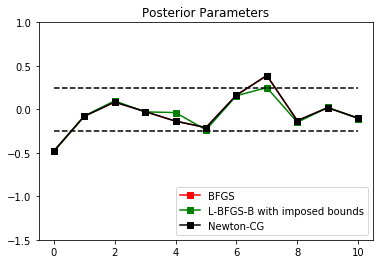

In [192]:
plt.plot(w_fit_BFGS,'rs-', label = 'BFGS')
plt.plot(w_fit_LBFGSB,'gs-', label = 'L-BFGS-B with imposed bounds')
plt.plot(w_fit,'ks-', label = 'Newton-CG')
plt.plot((0, 10), (0.25, 0.25), 'k--')
plt.plot((0, 10), (-0.25, -0.25), 'k--')
plt.ylim([-1.5,1.0])
plt.legend(loc = 'lower right')
plt.title('Posterior Parameters')

##### Plot the posterior Hessian

Text(0.5, 1.0, 'L-BFGS-B')

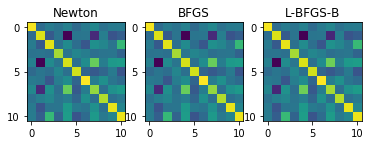

In [106]:
plt.subplot(1,3,1)
plt.imshow(H_fit)
plt.title('Newton')
plt.subplot(1,3,2)
plt.imshow(H_fit_BFGS)
plt.title('BFGS')
plt.subplot(1,3,3)
plt.imshow(H_fit_LBFGSB)
plt.title('L-BFGS-B')

### Support vector Machine (SVM)

After logistic regression(LR), we applied SVM. SVM minimizes hinge loss while logistic regression minimizes logistic loss. LR is more sensitive to outliers than SVM because the cost function of LR (hinge loss) diverges faster than that of SVM. As our data had outliers, we wanted to see if the presence of those outliers impacted the performance of LR on our data. This was the reason why we chose to apply SVM after LR. 

In [71]:
from sklearn.svm import SVC

In [253]:
#SVM – linear kernel
SVM_Linear = SVC(kernel='linear',random_state=0)
SVM_Linear.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

In [255]:
predictions = SVM_Linear.predict(X_test)

In [256]:
print(confusion_matrix(y_test,predictions))

[[40303     0]
 [25977     0]]


In [257]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76     40303
           1       0.00      0.00      0.00     25977

   micro avg       0.61      0.61      0.61     66280
   macro avg       0.30      0.50      0.38     66280
weighted avg       0.37      0.61      0.46     66280



D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
#SVM – default kernel
SVM_RBF = SVC(probability= True,random_state=0)
SVM_RBF.fit(X_train,y_train)

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

In [259]:
predictions2 = SVM_RBF.predict(X_test)

In [260]:
print(confusion_matrix(y_test,predictions2))

[[36350  3953]
 [19844  6133]]


In [261]:
print(classification_report(y_test,predictions2))

              precision    recall  f1-score   support

           0       0.65      0.90      0.75     40303
           1       0.61      0.24      0.34     25977

   micro avg       0.64      0.64      0.64     66280
   macro avg       0.63      0.57      0.55     66280
weighted avg       0.63      0.64      0.59     66280



For the basic model of SVM, we ran it with both default and linear kernel. The default kernel gave us a higher accuracy score of 0.6409625829812915. To further improve the score, we used RandomizedSearchCV. We did not use GridSearchCV as it is computationally very expensive for SVM. 

#### Random search cv

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.metrics import make_scorer, roc_auc_score

In [82]:
auc = make_scorer(roc_auc_score)
rand_list = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1)}
              
rand_search = RandomizedSearchCV(SVC(), param_distributions = rand_list, n_iter = 5, n_jobs = 4, cv = 2, random_state = 0, scoring = auc)

In [83]:
rand_search.fit(X_train_DT,y_train)

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=4,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024C81DBDCF8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000024C81DBB7B8>},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=make_scorer(roc_auc_score),
          verbose=0)

In [84]:
rand_search.cv_results_

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings

{'mean_fit_time': array([1982.81755853, 2101.69034803, 1910.82754636, 1762.59020281,
        1263.30670547]),
 'std_fit_time': array([60.99762702, 63.81812441, 35.26979113, 14.50671601, 63.0418601 ]),
 'mean_score_time': array([335.32353711, 332.02533424, 339.15301573, 343.79244626,
        167.01214802]),
 'std_score_time': array([8.31644344, 7.68522322, 0.06450355, 5.99892652, 0.48176944]),
 'param_C': masked_array(data=[7.4881350392732475, 8.027633760716439,
                    6.236547993389047, 6.375872112626925,
                    11.636627605010293],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.8151893663724195, 0.6448831829968968,
                    0.7458941130666561, 0.9917730007820797,
                    0.4834415188257777],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 7.4881350392732475, 'gamm

In [262]:
rand_search.best_score_

0.5624240035141701

RandomizedSearchCV did not help us in improving the accuracy score and thus we concluded that, the base model of SVM, with default kernel, gave us the highest accuracy score.

In [110]:
#Ramdomized Search CV did not help us in improving the accuracy
Best_Accuracy_SVM= SVM_RBF.score(X_test,y_test)
Best_Accuracy_SVM

0.6409625829812915

### Decision tree

Next, we applied Decision Tree (D-Tree). It helps  to quantify the values & probability of each possible outcome. Additionally, it is easy to implement, understand & visualize. The reason why we used this model on our data was to see if D-tree can help us in accurately predicting the target class based on all possible outcomes.

In [51]:
from sklearn.tree import DecisionTreeClassifier

In [52]:
dtree = DecisionTreeClassifier()

In [53]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [54]:
predictions = dtree.predict(X_test)

In [55]:
print(confusion_matrix(y_test,predictions))

[[27987 12316]
 [12025 13952]]


In [56]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.70      0.69      0.70     40303
           1       0.53      0.54      0.53     25977

   micro avg       0.63      0.63      0.63     66280
   macro avg       0.62      0.62      0.62     66280
weighted avg       0.63      0.63      0.63     66280



The base model of Decision Tree gave us an accuracy score of 0.6327549788774894. As Decision Trees suffer from the problem of overfitting, we tried to solve this problem by running Random Forest algorithm on our data, next. 

In [57]:
Best_Accuracy_DTree=dtree.score(X_test,y_test)
Best_Accuracy_DTree

0.6327549788774894

### Random Forest

As D-tree can suffer from the problem of our fitting, we next chose to run ensemble method, Random Forest, on our data. Random forest builds multiple D- trees & merges them to get more accurate & stable prediction. We used it to our data because it de-correlates the trees- resulting in  less variable and more reliable trees and thus, eliminates the problem of overfitting problem, which is generally experienced if we use decision trees.

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [228]:
rfc_pred = rfc.predict(X_test)

In [229]:
print(confusion_matrix(y_test,rfc_pred))

[[34386  5917]
 [13950 12027]]


In [230]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.71      0.85      0.78     40303
           1       0.67      0.46      0.55     25977

   micro avg       0.70      0.70      0.70     66280
   macro avg       0.69      0.66      0.66     66280
weighted avg       0.70      0.70      0.69     66280



In [231]:
rfc.score(X_test,y_test)

0.7002564876282438

The base Random Forest model gave us the accuracy score of 0.7002564876282438. To further improve it, we did RandomizedSearchCV. We did not do GridSearchCV as it is computationally very expensive for Random Forest model. 

#### Randomized search CV

In [27]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [28]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 3, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 40.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=3, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [29]:
rf_random.score(X_test,y_test)

0.7048129149064575

Though, RandomizedSearchCV gave us the results, it took a lot of time to run. To rectify this problem, we did feature selection and chose 5 most important features. 

##### Feature selection to improve accuracy of Random Forest

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.1048732  0.09812624 0.09881031 0.09885653 0.10015869 0.09901442
 0.11015632 0.09677147 0.09616472 0.09706811]


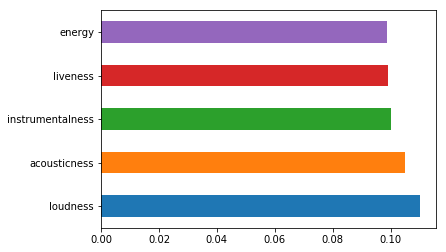

In [31]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

Using these 5 features, we ran Random Forest and RandomizedSearchCV

In [32]:
X_train_DT = X_train[["loudness","acousticness","energy","instrumentalness","duration_ms"]]
X_test_DT= X_test[["loudness","acousticness","energy","instrumentalness","duration_ms"]]

In [33]:
rfc_reduced = RandomForestClassifier(n_estimators=100)
rfc_reduced.fit(X_train_DT,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
rfc_pred_reduced = rfc_reduced.predict(X_test_DT)

In [51]:
print(confusion_matrix(y_test,rfc_pred_reduced))

[[39405  9051]
 [17429 13651]]


In [52]:
print(classification_report(y_test,rfc_pred_reduced))

              precision    recall  f1-score   support

           0       0.69      0.81      0.75     48456
           1       0.60      0.44      0.51     31080

   micro avg       0.67      0.67      0.67     79536
   macro avg       0.65      0.63      0.63     79536
weighted avg       0.66      0.67      0.65     79536



#### Ramdomized search CV on selected features

In [34]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [35]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_reduced = RandomizedSearchCV(estimator = rfc_reduced, param_distributions = random_grid, n_iter = 3, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_reduced.fit(X_train_DT,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 28.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=3, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [36]:
print(rf_random_reduced.best_score_)
print(rf_random_reduced.best_params_)
print(rf_random_reduced.best_estimator_)

0.6585981623323393
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


If we compare the accuracy score of the base model and different methods we used to tune our model, we see that we achieved the best accuracy from the model ran using RandomizedSearchCV with all features i.e. 0.7048129149064575

In [37]:
Best_Accuracy_RForest = rf_random.score(X_test,y_test)
#Using Randomized Grid search CV on all the features, our accuracy improved

### K-Nearest Neighbours (KNN)

Finally, we applied KNN on our data because it is based on feature similarity and is effective for large training data. 

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
knn = KNeighborsClassifier(n_neighbors=1)

In [22]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [23]:
pred = knn.predict(X_test)

In [26]:
print(confusion_matrix(y_test,pred))

[[27830 12473]
 [11415 14562]]


In [27]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70     40303
           1       0.54      0.56      0.55     25977

   micro avg       0.64      0.64      0.64     66280
   macro avg       0.62      0.63      0.62     66280
weighted avg       0.64      0.64      0.64     66280



We initiated this model with k=1. However, to find the optimal k, we plotted the misclassification (error rate) against different values of K, ranging from 1 to 30. Based on the graph, we chose K = 20 as it gave the lowest error rate. Similar rate was being given by k=24, however, the difference between the error rate does not suffice to select a larger K. 

In [113]:
error_rate = []

for i in range(1,30):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    

(0, 30)

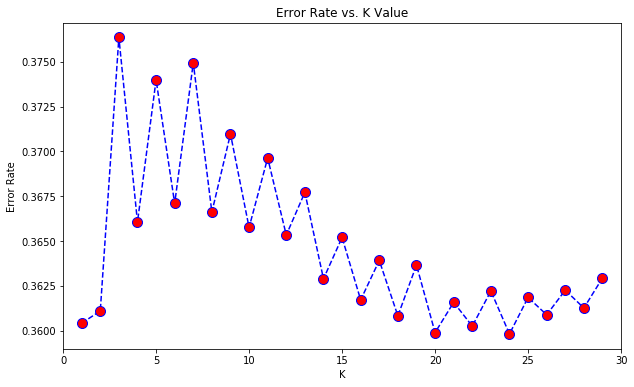

In [116]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.xlim(0,30)

In [20]:
# NOW WITH K=20
knn = KNeighborsClassifier(n_neighbors=20)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH K=20')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=20


[[32906  7397]
 [16456  9521]]


              precision    recall  f1-score   support

           0       0.67      0.82      0.73     40303
           1       0.56      0.37      0.44     25977

   micro avg       0.64      0.64      0.64     66280
   macro avg       0.61      0.59      0.59     66280
weighted avg       0.63      0.64      0.62     66280



In [21]:
knn.score(X_test,y_test)

0.6401176825588413

The base model of KNN (k=20) gave us an accuracy score of 0.6401176825588413. To further improve the accuracy score, we did GridSearchCV and RandomziedSearchCV.

#### Grid Search CV

In [61]:
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [62]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 22}

In [143]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.6169418261233635

#### Randomized Search CV

In [63]:
# specify "parameter distributions" rather than a "parameter grid"
k_range=(1,30)
weight_options = ['uniform', 'distance']
# since both parameters are discrete, so param_dist is the same as param_grid
param_dist = dict(n_neighbors=k_range, weights=weight_options)

# if parameters are continuous (like regularization)

In [64]:
# n_iter controls the number of searches

# instantiate model
# 2 new params
# n_iter --> controls number of random combinations it will try
# random_state for reproducibility 
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)

# fit
rand.fit(X_train, y_train)

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_neighbors': (1, 30), 'weights': ['uniform', 'distance']},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [65]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)
print(rand.best_estimator_)

0.6783478090314274
{'weights': 'distance', 'n_neighbors': 30}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=30, p=2,
           weights='distance')


Based on the accuracy score, we concluded that RandomizedSearchCV gave us the best accuracy score for KNN. 

In [108]:
Best_Accuracy_KNN=rand.best_score_

## Model Comparison and Results

For the 1st objective of the project, we wanted to evaluate all models together and see which model outperformed other. For this, we used two methods.
-AUC Curve
-Bar chart of best accuracy score obtained from each model

#### ROC Curve

In [67]:
from sklearn.metrics import make_scorer, roc_auc_score

In [68]:
from sklearn.metrics import roc_curve

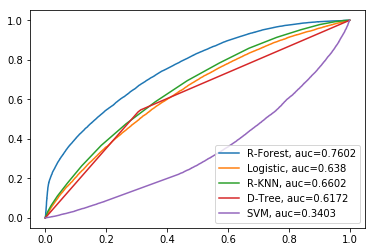

In [76]:
y_pred_proba_Logistic = grid_result.predict_proba(X_test)[::,1]
fpr_Logistic, tpr_Logistic, _ = roc_curve(y_test,  y_pred_proba_Logistic)
auc_logistic = round(roc_auc_score(y_test, y_pred_proba_Logistic),3)
y_pred_proba_DTree=dtree.predict_proba(X_test)[::,-1]
fpr_DTree, tpr_DTree, _ = roc_curve(y_test,  y_pred_proba_DTree)
auc_DTree = round(roc_auc_score(y_test, y_pred_proba_DTree),4)
y_pred_proba_RForest=rf_random.predict_proba(X_test)[::,-1]
fpr_RForest, tpr_RForest, _ = roc_curve(y_test,  y_pred_proba_RForest)
auc_RForest = round(roc_auc_score(y_test, y_pred_proba_RForest),4)
y_pred_proba_KNN=knn.predict_proba(X_test)[::,-1]
fpr_KNN, tpr_KNN, _ = roc_curve(y_test,  y_pred_proba_KNN)
auc_KNN = round(roc_auc_score(y_test, y_pred_proba_KNN),4)
y_pred_proba_SVM=SVM_RBF.predict_proba(X_test)[::,-1]
fpr_SVM, tpr_SVM, _ = roc_curve(y_test,  y_pred_proba_SVM)
auc_SVM = round(roc_auc_score(y_test, y_pred_proba_SVM),4)
plt.plot(fpr_RForest,tpr_RForest,label="R-Forest, auc="+str(auc_RForest))
plt.plot(fpr_Logistic,tpr_Logistic,label="Logistic, auc="+str(auc_logistic))
plt.plot(fpr_KNN,tpr_KNN,label="R-KNN, auc="+str(auc_KNN))
plt.plot(fpr_DTree,tpr_DTree,label="D-Tree, auc="+str(auc_DTree))
plt.plot(fpr_SVM,tpr_SVM,label="SVM, auc="+str(auc_SVM))

plt.legend(loc=4)
plt.show()

#### Bar Chart - Accuracy

In [111]:
Accuracy_List= [Best_Accuracy_Logistic,Best_Accuracy_BayesianLogistic,Best_Accuracy_DTree,Best_Accuracy_RForest,Best_Accuracy_KNN,Best_Accuracy_SVM]
Algorithms_Name= ["Logistic Regression", "Bayesian Logistic Regression", "Decision Tree", "Random Forest", "KNN", "SVM"]
Accuracy_df=pd.DataFrame(Algorithms_Name, columns=["Algorithms"])
Accuracy_df["Accuracy"] = Accuracy_List

In [112]:
Accuracy_df

Algorithms  Accuracy
0           Logistic Regression  0.627769
1  Bayesian Logistic Regression  0.626584
2                 Decision Tree  0.632755
3                 Random Forest  0.704813
4                           KNN  0.678348
5                           SVM  0.640963

In [319]:
Accuracy_df.dtypes

Algorithms     object
Accuracy      float64
dtype: object

In [113]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

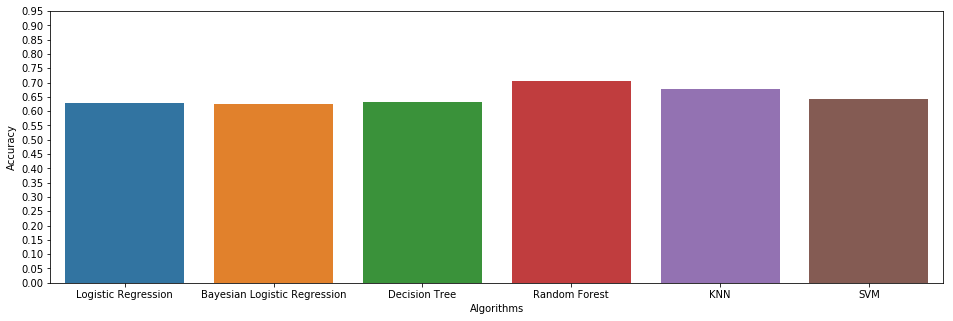

In [115]:
plt.figure(figsize=(16,5))
ax = sns.barplot(x="Algorithms", y="Accuracy", data=Accuracy_df)
ax.yaxis.set_ticks(np.arange(0.0, 1.0, 0.05))

From both the methods, we had used above, we concluded that Random Forest works best for our data.

# Part II - Unsupervised Learning (Personalized Song Recommender System)

Many music streaming services use primarily relational algorithms, which simply suggest songs from similar users’ playlists. And often, these music recommendations are not indicative of the kinds of music that the users enjoy. The objective for the second part of this project was to design a personalized song recommender system based on song’s audio feature.

For the purpose of our analysis we used the music dataset (consisting of songs from 1991 to 2018) containing song’s audio feature to identify song themes (using k-means clustering). We also had access to the user dataset containing 30 users like/dislike on selected songs. Since, there wasn’t a direct link between these two datasets, we used Mahalanobis method to link them together to get theme for each song in the user dataset. Finally, we designed a recommender system which recommends songs to a user if the selected song falls into their preferred theme.

**Unsupervised Learning Approach**

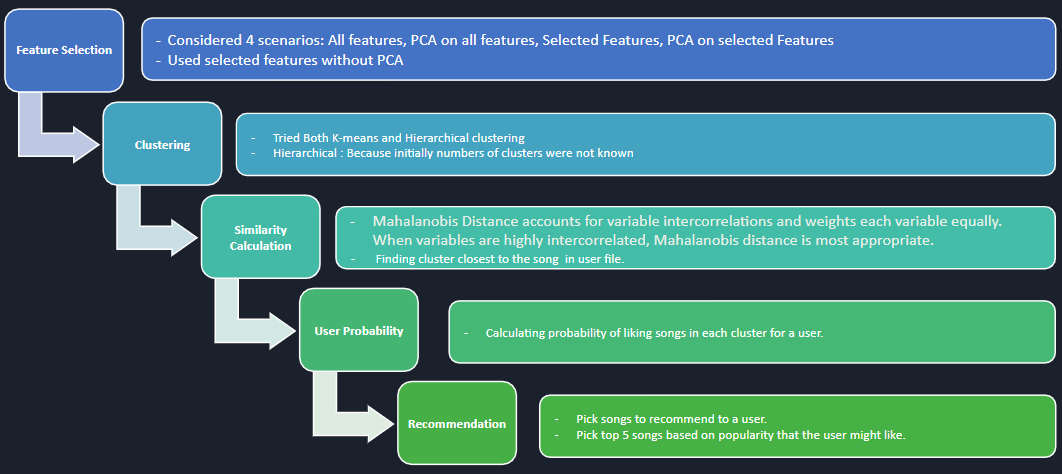

In [3]:
Image(filename='Part_2_Approach.PNG')

Music files from 1991 to 2018 were combined into a single file called "MergedMusic". There was basic data cleaning performed to get rid of irrelevant columns and null values for the purpose of this analysis.

In [4]:
#importing music data (merged 28 files)
MergedMusic = pd.read_csv(r'MergedMusic.csv', encoding='ISO-8859-1')
#viewing data for understanidng purpose
MergedMusic.head()

Index_Id  acousticness                album_id  \
0         0        0.1080  67nqYhvjDyJXGD64937Lw3   
1         1        0.4250  4S2ZR5njbJez1rV8DV5Vtl   
2         2        0.0468  0IyCnBPnQXafGgV0Jsa5Kq   
3         3        0.9480  0IyCnBPnQXafGgV0Jsa5Kq   
4         4        0.6300  3Fb7L1abcJbTt729nCq2eZ   

                        album_name  \
0  The Beach Boys' Christmas Album   
1                    Live In Japan   
2                 WWE: Uncaged VII   
3                 WWE: Uncaged VII   
4                 Best 1991 - 2004   

                                        analysis_url  \
0  https://api.spotify.com/v1/audio-analysis/5xlS...   
1  https://api.spotify.com/v1/audio-analysis/4gdh...   
2  https://api.spotify.com/v1/audio-analysis/3oix...   
3  https://api.spotify.com/v1/audio-analysis/0pNu...   
4  https://api.spotify.com/v1/audio-analysis/0z5E...   

                                          artist_ids  \
0  3oDbviiivRWhXwIE8hxkVV,03IJEZ6IynYczgge2uC4YD,...   
1                             7FIoB5PHdrMZVC3q2HE5MS   
2      6irRU9KRGb0cMtlsBZMg2i,0spHbv2fw49lDMkbOAdaqX   
3      6irRU9KRGb0cMtlsBZMg2i,0spHbv2fw49lDMkbOAdaqX   
4                             5GtMEZEeFFsuHY8ad4kOxv   

                                   artist_names  danceability  disc_number  \
0  The Beach Boys,Mark Linett,Sweet,Larry Walsh         0.602            1   
1                               George Harrison         0.611            2   
2                              Jim Johnston,WWE         0.737            1   
3                              Jim Johnston,WWE         0.340            1   
4                                          Seal         0.587            1   

   duration_ms   ...    popularity  \
0       118840   ...            72   
1       211320   ...            62   
2       208573   ...            18   
3       230500   ...            18   
4       289227   ...            53   

                                         preview_url                 song_id  \
0                                                NaN  5xlS0QkVrSH7ssEbBgBzbM   
1                                                NaN  4gdhsYfXJoVQsWpbmh32Da   
2  https://p.scdn.co/mp3-preview/550b95f0c09acdc4...  3oixYd5Q41mfwfwpc2LuYx   
3  https://p.scdn.co/mp3-preview/1491f1d438cea7b5...  0pNu2I9Jbio4lLVO6H0lE1   
4  https://p.scdn.co/mp3-preview/70c682670b19c965...  0z5E34e7ZT3XKMYQNXh6tH   

                                           song_name  speechiness    tempo  \
0                     Little Saint Nick - 1991 Remix       0.0328  130.594   
1  Here Comes The Sun - Live In Japan/1991/Remast...       0.0295  125.240   
2                             Beware the Bull (1991)       0.0344  145.003   
3                                    Mount Up (1991)       0.0284  110.588   
4                                   Kiss From A Rose       0.0296  131.727   

   time_signature                                         track_href  \
0             4.0  https://api.spotify.com/v1/tracks/5xlS0QkVrSH7...   
1             4.0  https://api.spotify.com/v1/tracks/4gdhsYfXJoVQ...   
2             4.0  https://api.spotify.com/v1/tracks/3oixYd5Q41mf...   
3             4.0  https://api.spotify.com/v1/tracks/0pNu2I9Jbio4...   
4             3.0  https://api.spotify.com/v1/tracks/0z5E34e7ZT3X...   

  track_number valence  
0            1  0.9710  
1            2  0.6390  
2            4  0.8590  
3            5  0.0866  
4            2  0.2100  

[5 rows x 26 columns]

There are 26 columns and 265,120 rows in the "MergedMusic" dataset. "Preview url" was removed as it had 35,105 null values and further it does not add any value to this analysis. Also, four more columns ("danceability", "speechiness", "valence" and "time_signature") had one null value each, so it made more sense to get rid of these rows from "MergedMusic" dataset.

In [5]:
MergedMusic.shape

(265120, 26)

In [6]:
MergedMusic.isnull().sum()

Index_Id                0
acousticness            0
album_id                0
album_name              0
analysis_url            0
artist_ids              0
artist_names            0
danceability            1
disc_number             0
duration_ms             0
energy                  0
instrumentalness        0
key                     0
liveness                0
loudness                0
mode                    0
popularity              0
preview_url         35105
song_id                 0
song_name               0
speechiness             1
tempo                   0
time_signature          1
track_href              0
track_number            0
valence                 1
dtype: int64

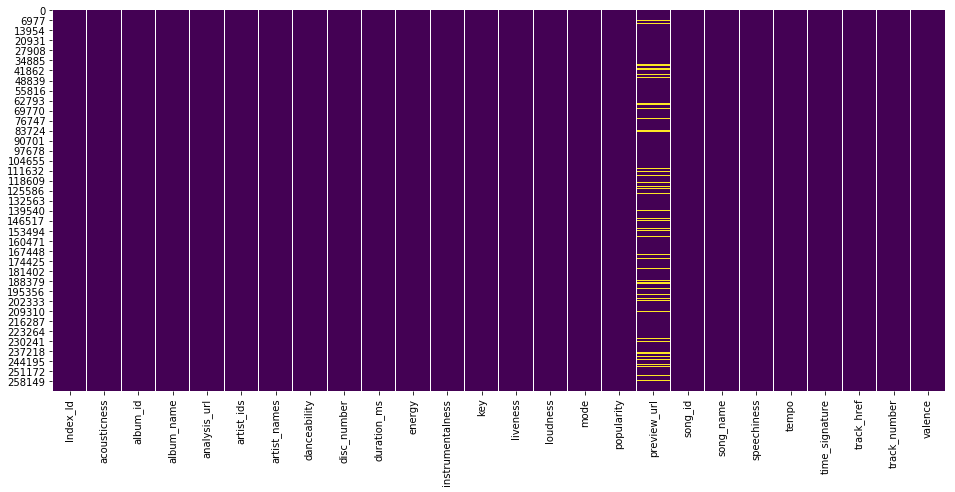

In [7]:
plt.figure(figsize=(16,7))
sns.heatmap(MergedMusic.isnull(),cmap='viridis',cbar=False)

There are no more null values in the dataset as it can be seen from above summary. The new DataFrame is called “MergedMusic_clean”.

In [8]:
#keeping relevant columns. Need to explain why we removed the other columns.
MergedMusic_clean = MergedMusic
drop_col = ['analysis_url', 'preview_url', 'track_href', 'time_signature']

MergedMusic_clean.drop(drop_col, inplace = True, axis =1)

MergedMusic_clean = MergedMusic_clean.dropna()

MergedMusic_clean.isnull().sum()

Index_Id            0
acousticness        0
album_id            0
album_name          0
artist_ids          0
artist_names        0
danceability        0
disc_number         0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
popularity          0
song_id             0
song_name           0
speechiness         0
tempo               0
track_number        0
valence             0
dtype: int64

### Feature Selection & Clustering

Below four scenarios were considered to find the sceario with most apprpriate clusters and features to be used for the personalised recommender system. Scenario 4 **(Selected features without PCA)** was used for the recommender system. Features like tempo, key, loudness, mode, instrumentalness, speechiness were removed as they did not uniquly identify the clusters shown below.

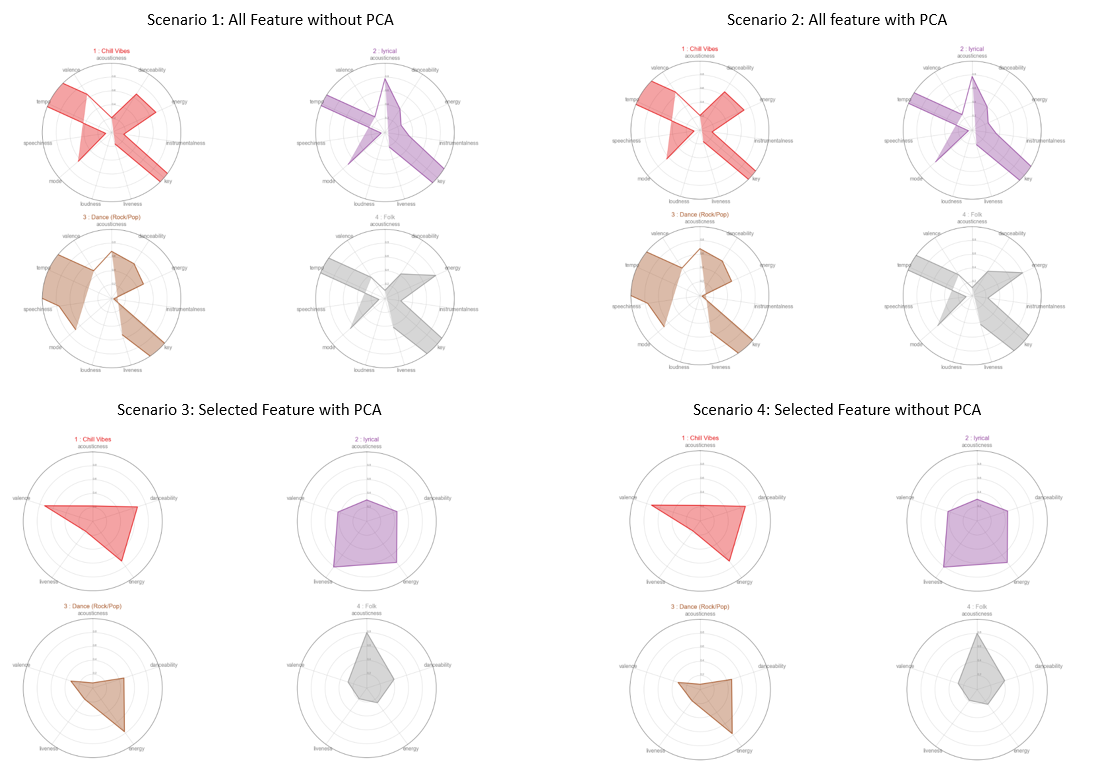

In [11]:
Image(filename='Part_2_Radarchart.PNG')

#### Feature Scaling

clustering relies on distance, the scale of the data will affect the results. This means that weight will be dominant in determining the clusters. The features were standardized to make sure no one feature is influencing the clusters.

**Scaling: All Audio Features**

A new DataFrame called "df_cluster_all" is created. This consists of all auido features. These features were then scaled using StandardScaler funtion. The idea behind StandardScaler is that it will transform the data such that its distribution will have a mean value 0 and standard deviation of 1.

In [12]:
#All audio features
cluster_features_all = ['acousticness','danceability','energy','instrumentalness','key','liveness','loudness','mode',     
                    'speechiness','tempo','valence']
df_cluster_all = MergedMusic_clean[cluster_features_all]

df_cluster_all_scale = np.array(df_cluster_all)
scaler = StandardScaler()
scaler.fit(df_cluster_all_scale)
df_cluster_all_scale = scaler.transform(df_cluster_all_scale)

**Scaling: Selected Audio Features**

A new DataFrame called "df_cluster_selected" is created. This consists of all auido features. These features were then scaled using StandardScaler funtion. The idea behind StandardScaler is that it will transform the data such that its distribution will have a mean value 0 and standard deviation of 1.

In [13]:
#Selected audio features
cluster_features_selected = ['acousticness','danceability','energy','liveness','valence']
df_cluster_selected = MergedMusic_clean[cluster_features_selected]


df_cluster_selected_scale = np.array(df_cluster_selected)
scaler = StandardScaler()
scaler.fit(df_cluster_selected_scale)
df_cluster_selected_scale = scaler.transform(df_cluster_selected_scale)

Defining Radar chart code. Reference: https://python-graph-gallery.com/392-use-faceting-for-radar-chart/

In [14]:
def make_radar(row, title, color, dframe, num_clusters):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(2,ceil(num_clusters/2),row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)

    # Ind1
    values=dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=16, color=color, y=1.06)

#### Elbow Method

K-means clustering is used in the unsupervised learning to design a personalised song recommender system. K-means clustering method requires explicit number of clusters (k) to be defined. One approach is to specify the value of k based on knowledge. Another way is to use elbow method to determine the number of clusters.

Each point is taken and its sqaure distance is measured to thier cluster centroids, called sum of sqaure distance (SSD). This process is repeated for all the data points and for each value of k. SSD measures how close each points are to the cluster centroid. Therefore, the smaller the SSD, the closer the points are in the same cluster.

**Elbow Method: All Audio Features**

In [15]:
ss_dist = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k, max_iter=10, init='k-means++', random_state=123)
    km = km.fit(df_cluster_all_scale)
    ss_dist.append(km.inertia_)

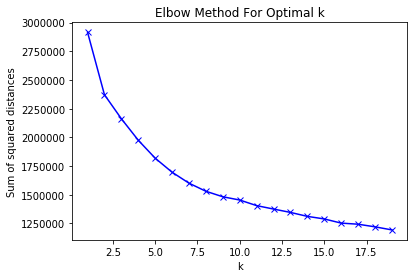

In [16]:
plt.plot(K, ss_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

**Elbow Method: Selected Audio Features**

In [17]:
ss_dist = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k, max_iter=10, init='k-means++', random_state=123)
    km = km.fit(df_cluster_selected_scale)
    ss_dist.append(km.inertia_)

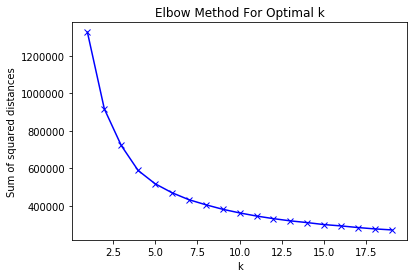

In [18]:
plt.plot(K, ss_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From the above elbow method for both all and selected audio feature, it can be concluded that the optimal number of clusters is 4 as there is a considerable amount of reduction in total within-clusters sum of squared variation.

#### Scenario 1: All audio features without PCA

In the first scenario, all the features are considered. The value of k is specifed to be 4 based on the above elbow method analysis.

In [19]:
num_clusters = 4
kmeanModel_s1 = KMeans(n_clusters=num_clusters, max_iter=100, init='k-means++', random_state=123).fit(df_cluster_all_scale)

**Visualisation of cluster**

Here all the features are considered and hence the number of components in PCA is taken as 11.

In [20]:
pca_s1 = PCA(n_components=11, random_state=123)
pca_results_s1 = pca_s1.fit_transform(df_cluster_all_scale)

print(pca_s1.explained_variance_ratio_.sum())
pca_s1.explained_variance_ratio_.cumsum()

df_scree_s1 = pd.DataFrame({'Component': ['1','2','3','4','5','6','7','8','9','10','11'],'Indiv':pca_s1.explained_variance_ratio_})
df_scree_s1['cum_sum'] = df_scree_s1['Indiv'].cumsum()
df_scree_s1

1.0000000000000002


Component     Indiv   cum_sum
0          1  0.261952  0.261952
1          2  0.126343  0.388296
2          3  0.121739  0.510035
3          4  0.107903  0.617937
4          5  0.082339  0.700276
5          6  0.078626  0.778902
6          7  0.072543  0.851445
7          8  0.061161  0.912606
8          9  0.039857  0.952463
9         10  0.034669  0.987132
10        11  0.012868  1.000000

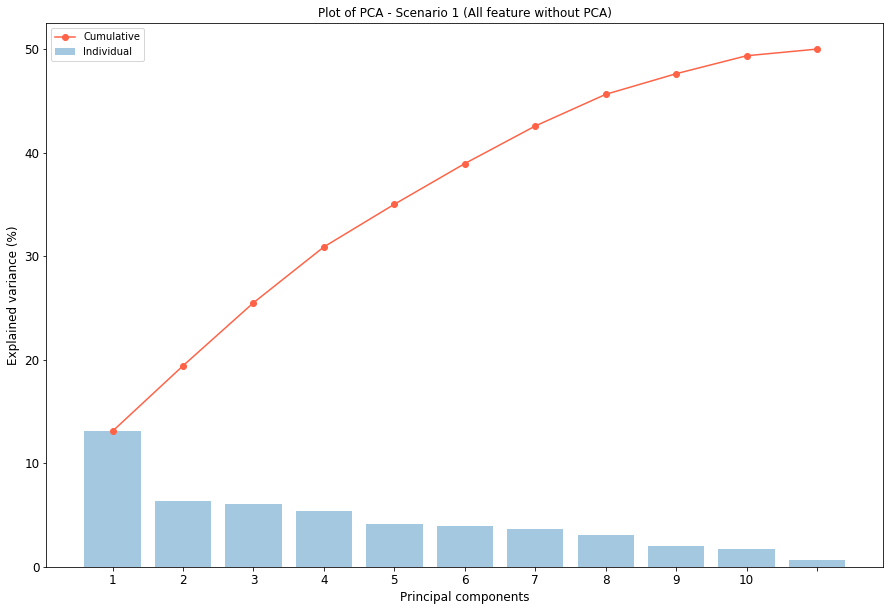

In [21]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(range(len(pca_s1.explained_variance_ratio_)), pca_s1.explained_variance_ratio_, 
        label='Individual', axes=ax, alpha=0.4)
plt.plot(range(len(pca_s1.explained_variance_ratio_)), pca_s1.explained_variance_ratio_.cumsum(), 
         label='Cumulative', color='tomato', axes=ax, marker='o')

ax.set_xticks(range(0,11))
ax.set_xticklabels(range(1,11), fontsize=12)
ax.set_yticklabels(range(0,90,10), fontsize=12)

plt.title('Plot of PCA - Scenario 1 (All feature without PCA)', fontsize=12)
plt.ylabel('Explained variance (%)', fontsize=12)
plt.xlabel('Principal components', fontsize=12)
plt.legend()
plt.show()

It can be seen from the above graph that 85% of the variance in data is explained by 6 components.

In [22]:
df_pca_s1 = pd.DataFrame(pca_results_s1)
df_pca_s1.columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11']
df_pca_s1['label'] = kmeanModel_s1.labels_
df_pca_s1.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.127446  0.757773 -1.361523  0.069222 -1.474741 -1.011194 -0.857084   
1 -0.206315  0.820234  1.233996  0.288692 -1.052684 -0.678444 -0.658654   
2 -1.343419 -0.438705 -1.571943 -1.611302  1.885155 -0.208582 -0.393428   
3  2.407256 -1.213426 -0.461562 -0.079710 -0.378431 -0.261143 -1.077030   
4  0.542618  0.049672 -0.042922 -0.189888 -1.066715 -0.652313 -0.319189   

        PC8       PC9      PC10      PC11  label  
0 -0.149353 -0.467919  0.860187 -0.411085      0  
1 -1.881128  0.896101  0.279952  0.072720      3  
2 -1.025482 -0.392745  0.212297 -0.032652      0  
3  0.243921 -0.297810 -1.821484 -0.660467      1  
4  0.477396  0.987461 -0.881783  0.161878      0

**2-D Scatter Plot of Scenario 1**

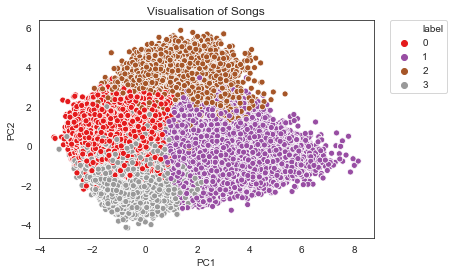

In [23]:
sns.set_style('white')
sns.scatterplot(data=df_pca_s1, x='PC1', y='PC2', hue='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisation of Songs')
plt.show()

It can be seen from the above cluster plot that there is some overlap between the red and grey cluster. Clusters are overlaping even further when the value of k is increased in the k-means algorithm.

**3-D Scatter Plot of Scenario 1**

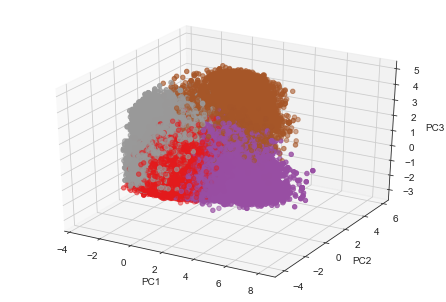

In [24]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca_s1['PC1'], df_pca_s1['PC2'], df_pca_s1['PC3'],
           c=df_pca_s1['label'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

**Song feature distribution compared to overall distribution**

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


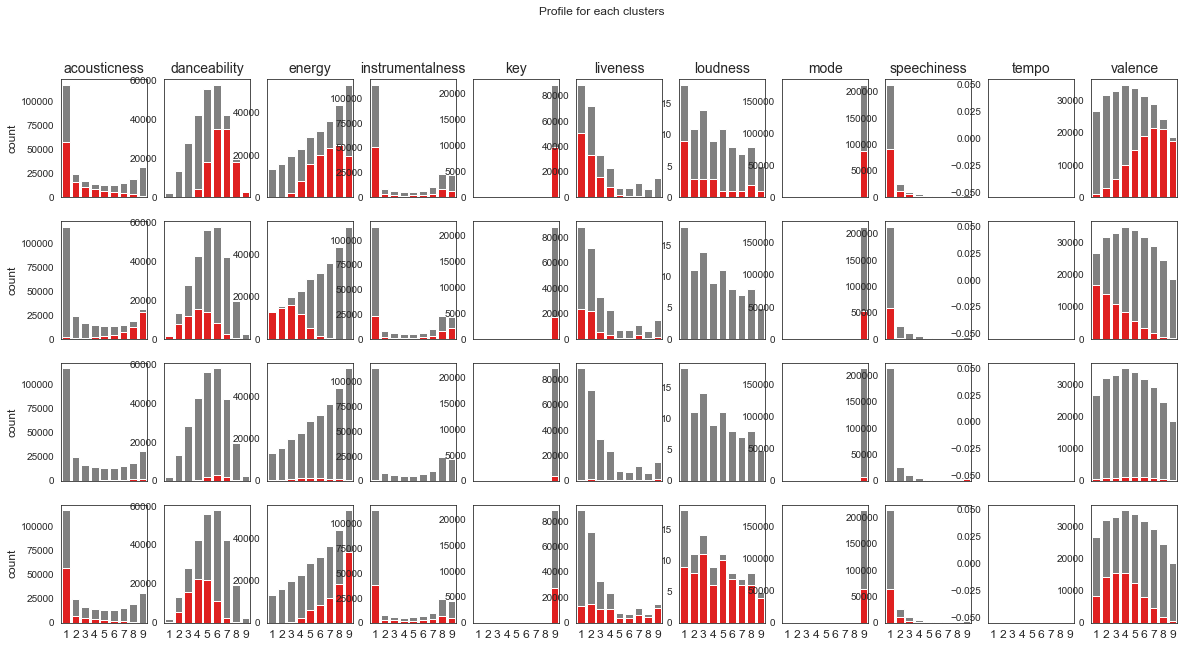

In [25]:
MergedMusic_clean.loc[:,'cluster'] = kmeanModel_s1.labels_
# set binning intervals of 0.1
bins = np.linspace(0,1,10)

# create subplots
num_features = len(cluster_features_all)
f, axes = plt.subplots(num_clusters, num_features, 
                       figsize=(20, 10), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(MergedMusic_clean['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster_all_scale = MergedMusic_clean[MergedMusic_clean['cluster'] == cluster]
    col = 0
    
    for feature in cluster_features_all:
#         create binned count for all recent df and clustered df
        rec_grp = MergedMusic_clean.groupby(pd.cut(MergedMusic_clean[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster_all_scale.groupby(pd.cut(df_cluster_all_scale[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='red', ax=axes[row, col])
        
#         configure ax
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(range(1,10), fontsize=12)
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel('count', fontsize=12)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14)        
        col += 1
    row += 1
    
f.suptitle('Profile for each clusters')
    
plt.show()

In the above graph, each row represents the cluster, 0 to 3, and each column represents the feature. The **grey bar** represents the distribution of the feature. This gives a rough idea of the distribution of the feature. The **red bar** represents the distribution of the feature in that cluster which is used to compare against the other clusters.

Looking at the distribution of each cluster, it can be seen that each cluster is high or low in certain features. This is identified by whether the red bar is on the right(high) or left(low) with respect to the grey bar. From these characteristics, songs can be profiled into different themes.

**Interpretation of each feature:**
-	**Acousticness:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is low for cluster 0 and 3 while high for cluster 1. It has no effect on cluster 2.

-	**Danceability:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is high for cluster 0 while in the middle for cluster 1 and 3. It has very little effect on cluster 2.

-	**Energy:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is high for cluster 0 and 1 while low for cluster 1. It has no effect on cluster 2.

-	**Instrumentalness:** This feature is not uniquely identifying the clusters as it can be seen from the above graph. The distribution seems similar across all the clusters.

-	**Key:** This feature is not uniquely identifying the clusters as it can be seen from the above graph. The distribution seems similar across all the clusters.

-	**Liveness:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is low for cluster 0 and 1. It has no effect on cluster 2 and is distributed across for cluster 3.

-	**Loudness:** This feature is not uniquely identifying the clusters as it can be seen from the above graph. The distribution seems similar across all the clusters.

-	**Mode:** This feature is not uniquely identifying the clusters as it can be seen from the above graph. The distribution seems similar across all the clusters.

-	**Speechiness:** This feature is not uniquely identifying the clusters as it can be seen from the above graph. The distribution seems similar across all the clusters.

-	**Tempo:** This feature is not uniquely identifying the clusters as it can be seen from the above graph. The distribution seems similar across all the clusters.

-	**Valence:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is high for cluster 0 while low for cluster 1. It has no effect on cluster 2 and is distributed across for cluster 3.

**Average song features per cluster**

It is easier to view the difference between all the clusters at a glance. So, radar chat of average of cluster feature was plotted.

In [26]:
# calculate mean of each variable
radar_col = cluster_features_all + ['cluster']

# feature average for each cluster as a radar chart
df_radar_all = MergedMusic_clean[radar_col]
df_radar_all = df_radar_all.groupby('cluster').mean().reset_index()

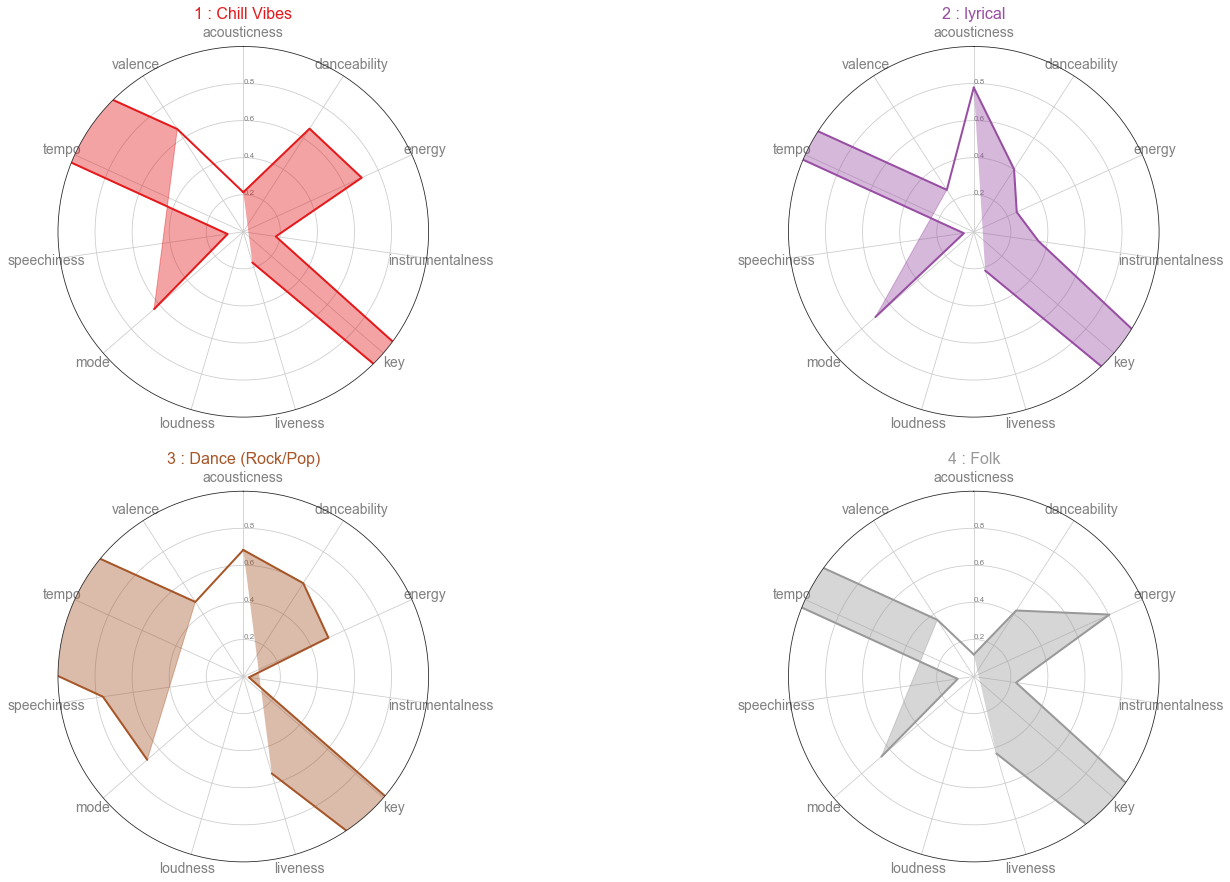

In [27]:
# initialize the figure
plt.figure(figsize=(24,15))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set1", len(df_radar_all.index))

# Create cluster name
title_list = ['Chill Vibes', 'lyrical', 'Dance (Rock/Pop)', 'Folk']

# Loop to plot
for row in range(0, len(df_radar_all.index)):
    make_radar(row=row, title=str(df_radar_all['cluster'][row]+1) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar_all, num_clusters=len(df_radar_all.index))

title=str(df_radar_all['cluster'][row]) + ' : ' + title_list[row],
# Show plot
plt.show()

The readings of the radar chart is similar to the profile given above.

**Interpretation of each Cluster:**

**Cluster 0 (1: Chill Vibes):** 

- **High:** Danceability, Energy, Key, Mode, Tempo, Valence. 

- **Low:** Acousticness, Instrumentalness, Liveness, Loudness, Speechiness.


**Cluster 1 (2: Lyrical):** 

- **High:** Acousticness, Key, Mode, Tempo. 

- **Low:** Danceability, Energy, Instrumentalness, Liveness, Loudness, Speechiness, Valence.

**Cluster 2 (3: Dance (Rock/Pop)):**

- **High:** Acousticness, Danceability, Energy, Key, Liveness, Mode, Speechiness, Tempo, Valence. 

- **Low:** Instrumentalness, Loudness.

**Cluster 3 (4: Folk):**

- **High:** Energy, Key, Mode, Tempo. 

- **Low:** Acousticness, Danceability, Instrumentalness, Liveness, Loudness, Speechiness, Valence.

#### Scenario 2: All audio features with PCA

In [28]:
#All audio features
cluster_features_all = ['acousticness','danceability','energy','instrumentalness','key','liveness','loudness','mode',     
                    'speechiness','tempo','valence']
df_cluster_all = MergedMusic_clean[cluster_features_all]

df_cluster_all_scale = np.array(df_cluster_all)
scaler = StandardScaler()
scaler.fit(df_cluster_all_scale)
df_cluster_all_scale = scaler.transform(df_cluster_all_scale)

In [29]:
num_clusters = 4
kmeanModel_s2 = KMeans(n_clusters=num_clusters, max_iter=100, init='k-means++', random_state=123).fit(df_cluster_all_scale)

**Visualisation of cluster**

Here all the features are considered and the number of components in PCA is taken as 6. This is based on sceario 1, where it was shown that 6 components were able to explain 85% of the variance.

In [30]:
pca_s2 = PCA(n_components=6, random_state=123)
pca_results_s2 = pca_s2.fit_transform(df_cluster_all_scale)

print(pca_s2.explained_variance_ratio_.sum())
pca_s2.explained_variance_ratio_.cumsum()

df_scree_s2 = pd.DataFrame({'Component': ['1','2','3','4','5','6'],'Indiv':pca_s2.explained_variance_ratio_})
df_scree_s2['cum_sum'] = df_scree_s2['Indiv'].cumsum()
df_scree_s2

0.7789024056663469


Component     Indiv   cum_sum
0         1  0.261952  0.261952
1         2  0.126343  0.388296
2         3  0.121739  0.510035
3         4  0.107903  0.617937
4         5  0.082339  0.700276
5         6  0.078626  0.778902

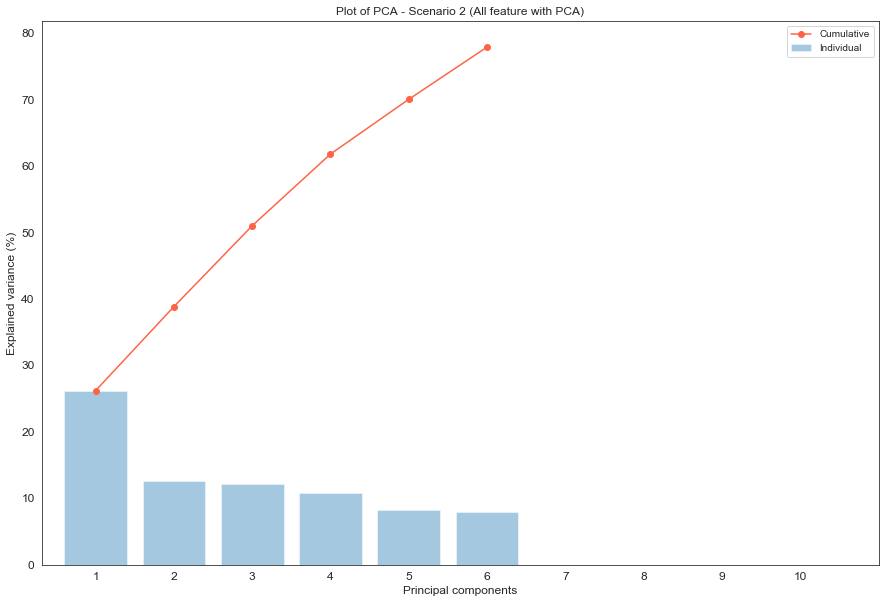

In [31]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(range(len(pca_s2.explained_variance_ratio_)), pca_s2.explained_variance_ratio_, 
        label='Individual', axes=ax, alpha=0.4)
plt.plot(range(len(pca_s2.explained_variance_ratio_)), pca_s2.explained_variance_ratio_.cumsum(), 
         label='Cumulative', color='tomato', axes=ax, marker='o')

ax.set_xticks(range(0,11))
ax.set_xticklabels(range(1,11), fontsize=12)
ax.set_yticklabels(range(0,90,10), fontsize=12)

plt.title('Plot of PCA - Scenario 2 (All feature with PCA)', fontsize=12)
plt.ylabel('Explained variance (%)', fontsize=12)
plt.xlabel('Principal components', fontsize=12)
plt.legend()
plt.show()

It can be seen from the above graph that 77% of the variance in data is explained by 6 components.

In [32]:
df_pca_s2 = pd.DataFrame(pca_results_s2)
df_pca_s2.columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6']
df_pca_s2['label'] = kmeanModel_s2.labels_
df_pca_s2.head()

PC1       PC2       PC3       PC4       PC5       PC6  label
0 -1.127446  0.757773 -1.361523  0.069222 -1.474741 -1.011194      0
1 -0.206315  0.820234  1.233996  0.288692 -1.052684 -0.678444      3
2 -1.343419 -0.438705 -1.571943 -1.611302  1.885155 -0.208582      0
3  2.407256 -1.213426 -0.461562 -0.079710 -0.378431 -0.261143      1
4  0.542618  0.049672 -0.042922 -0.189888 -1.066715 -0.652313      0

**2-D Scatter Plot of Scenario 2**

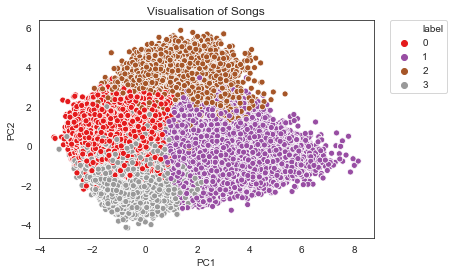

In [33]:
sns.set_style('white')
sns.scatterplot(data=df_pca_s2, x='PC1', y='PC2', hue='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisation of Songs')
plt.show()

It can be seen from the above cluster plot that there is some overlap between the red and grey cluster. Clusters are overlaping even further when the value of k is increased in the k-means algorithm.

**3-D Scatter Plot of Scenario 2**

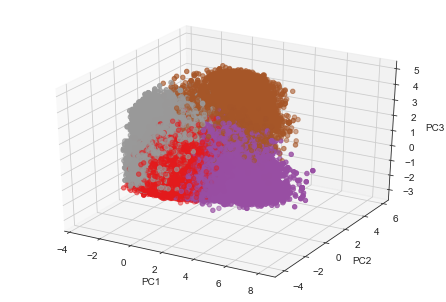

In [34]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca_s2['PC1'], df_pca_s2['PC2'], df_pca_s2['PC3'],
           c=df_pca_s2['label'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

**Song feature distribution compared to overall distribution**

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


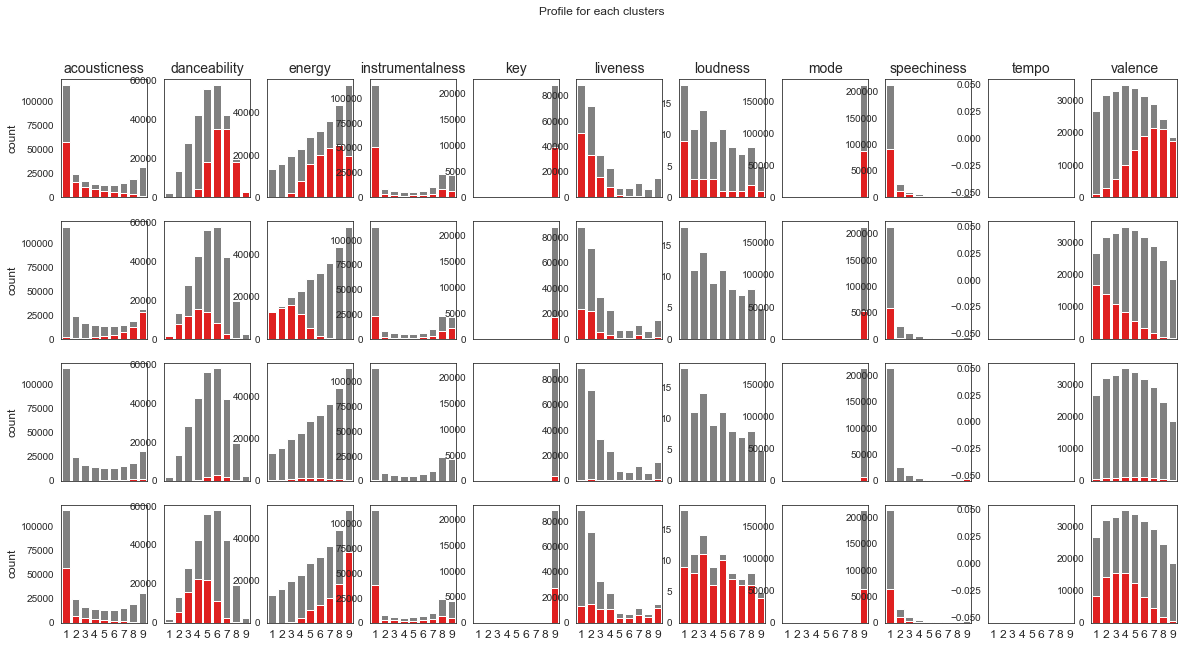

In [35]:
MergedMusic_clean.loc[:,'cluster'] = kmeanModel_s2.labels_
# set binning intervals of 0.1
bins = np.linspace(0,1,10)

# create subplots
num_features = len(cluster_features_all)
f, axes = plt.subplots(num_clusters, num_features, 
                       figsize=(20, 10), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(MergedMusic_clean['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster_all_scale = MergedMusic_clean[MergedMusic_clean['cluster'] == cluster]
    col = 0
    
    for feature in cluster_features_all:
#         create binned count for all recent df and clustered df
        rec_grp = MergedMusic_clean.groupby(pd.cut(MergedMusic_clean[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster_all_scale.groupby(pd.cut(df_cluster_all_scale[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='red', ax=axes[row, col])
        
#         configure ax
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(range(1,10), fontsize=12)
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel('count', fontsize=12)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14)        
        col += 1
    row += 1
    
f.suptitle('Profile for each clusters')
    
plt.show()

In the above graph, each row represents the cluster, 0 to 3, and each column represents the feature. The **grey bar** represents the distribution of the feature. This gives a rough idea of the distribution of the feature. The **red bar** represents the distribution of the feature in that cluster which is used to compare against the other clusters.

Looking at the distribution of each cluster, it can be seen that each cluster is high or low in certain features. This is identified by whether the red bar is on the right(high) or left(low) with respect to the grey bar. From these characteristics, songs can be profiled into different themes.

**Interpretation of each feature:**
-	**Acousticness:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is low for cluster 0 and 3 while high for cluster 1. It has no effect on cluster 2.

-	**Danceability:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is high for cluster 0 while in the middle for cluster 1 and 3. It has very little effect on cluster 2.

-	**Energy:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is high for cluster 0 and 1 while low for cluster 1. It has no effect on cluster 2.

-	**Instrumentalness:** This feature is not uniquely identifying the clusters as it can be seen from the above graph. The distribution seems similar across all the clusters.

-	**Key:** This feature is not uniquely identifying the clusters as it can be seen from the above graph. The distribution seems similar across all the clusters.

-	**Liveness:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is low for cluster 0 and 1. It has no effect on cluster 2 and is distributed across for cluster 3.

-	**Loudness:** This feature is not uniquely identifying the clusters as it can be seen from the above graph. The distribution seems similar across all the clusters.

-	**Mode:** This feature is not uniquely identifying the clusters as it can be seen from the above graph. The distribution seems similar across all the clusters.

-	**Speechiness:** This feature is not uniquely identifying the clusters as it can be seen from the above graph. The distribution seems similar across all the clusters.

-	**Tempo:** This feature is not uniquely identifying the clusters as it can be seen from the above graph. The distribution seems similar across all the clusters.

-	**Valence:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is high for cluster 0 while low for cluster 1. It has no effect on cluster 2 and is distributed across for cluster 3.

**Average song features per cluster**

In [36]:
# calculate mean of each variable
radar_col_PCA = cluster_features_all + ['cluster']

# feature average for each cluster as a radar chart
df_radar_all_PCA = MergedMusic_clean[radar_col_PCA]
df_radar_all_PCA = df_radar_all_PCA.groupby('cluster').mean().reset_index()

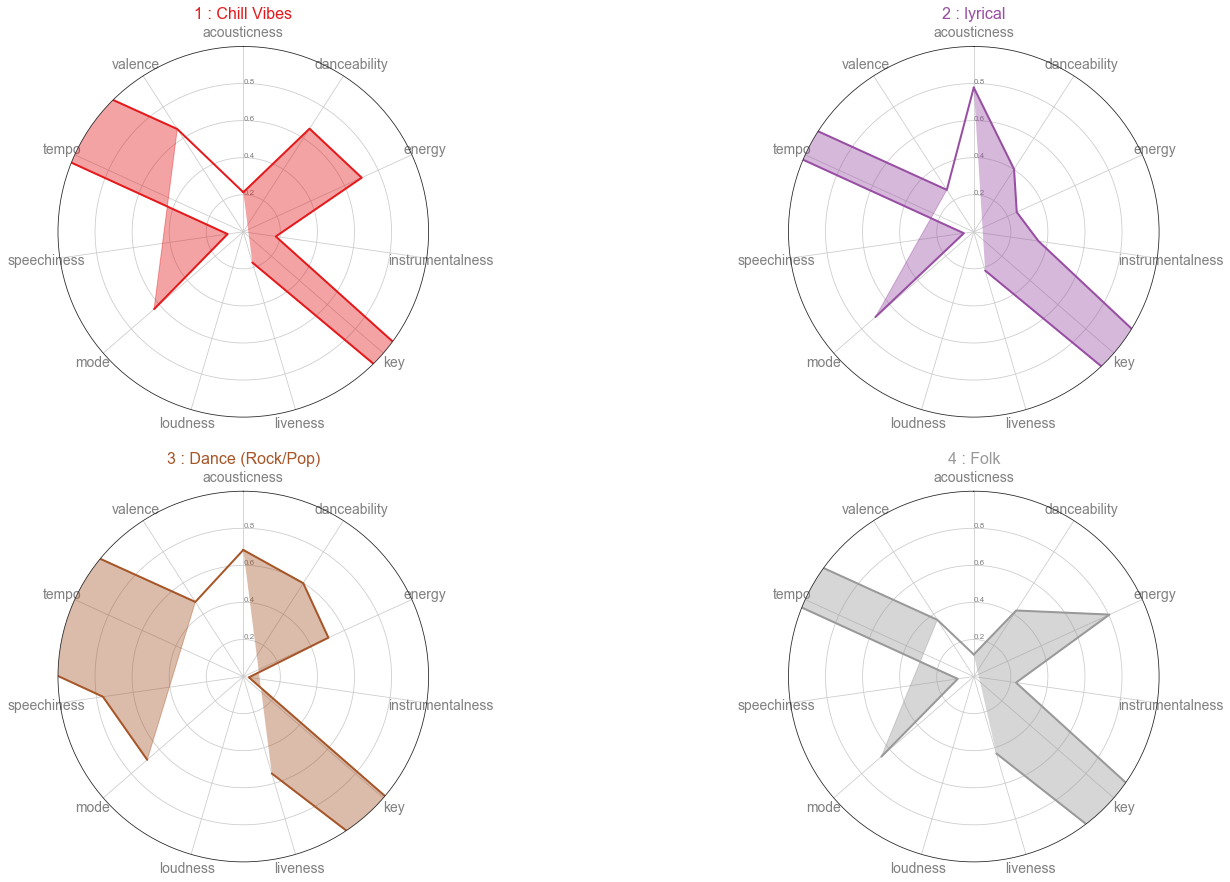

In [37]:
# initialize the figure
plt.figure(figsize=(24,15))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set1", len(df_radar_all_PCA.index))

# Create cluster name
title_list = ['Chill Vibes', 'lyrical', 'Dance (Rock/Pop)', 'Folk']

# Loop to plot
for row in range(0, len(df_radar_all_PCA.index)):
    make_radar(row=row, title=str(df_radar_all_PCA['cluster'][row]+1) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar_all_PCA, num_clusters=len(df_radar_all_PCA.index))

title=str(df_radar_all_PCA['cluster'][row]) + ' : ' + title_list[row],
# Show plot
plt.show()

The readings of the radar chart is similar to the profile given above.

**Interpretation of each Cluster:**

**Cluster 0 (1: Chill Vibes):** 

- **High:** Danceability, Energy, Key, Mode, Tempo, Valence. 

- **Low:** Acousticness, Instrumentalness, Liveness, Loudness, Speechiness.


**Cluster 1 (2: Lyrical):** 

- **High:** Acousticness, Key, Mode, Tempo. 

- **Low:** Danceability, Energy, Instrumentalness, Liveness, Loudness, Speechiness, Valence.

**Cluster 2 (3: Dance (Rock/Pop)):**

- **High:** Acousticness, Danceability, Energy, Key, Liveness, Mode, Speechiness, Tempo, Valence. 

- **Low:** Instrumentalness, Loudness.

**Cluster 3 (4: Folk):**

- **High:** Energy, Key, Mode, Tempo. 

- **Low:** Acousticness, Danceability, Instrumentalness, Liveness, Loudness, Speechiness, Valence.

#### Scenario 3: Selected audio features with PCA

In [38]:
#Selected audio features
cluster_features_selected = ['acousticness','danceability','energy','liveness','valence']
df_cluster_selected = MergedMusic_clean[cluster_features_selected]


df_cluster_selected_scale = np.array(df_cluster_selected)
scaler = StandardScaler()
scaler.fit(df_cluster_selected_scale)
df_cluster_selected_scale = scaler.transform(df_cluster_selected_scale)

In [39]:
num_clusters = 4
kmeanModel_s3 = KMeans(n_clusters=num_clusters, max_iter=100, init='k-means++', random_state=123).fit(df_cluster_selected_scale)

**Visualisation of cluster**

Here selected features are considered and number of components in PCA is taken as 3.

In [40]:
pca_s3 = PCA(n_components=3, random_state=123)
pca_results_s3 = pca_s3.fit_transform(df_cluster_selected_scale)

print(pca_s3.explained_variance_ratio_.sum())
pca_s3.explained_variance_ratio_.cumsum()

df_scree_s3 = pd.DataFrame({'Component': ['1','2','3'],'Indiv':pca_s3.explained_variance_ratio_})
df_scree_s3['cum_sum'] = df_scree_s3['Indiv'].cumsum()
df_scree_s3

0.8553437943328644


Component     Indiv   cum_sum
0         1  0.420501  0.420501
1         2  0.259716  0.680217
2         3  0.175126  0.855344

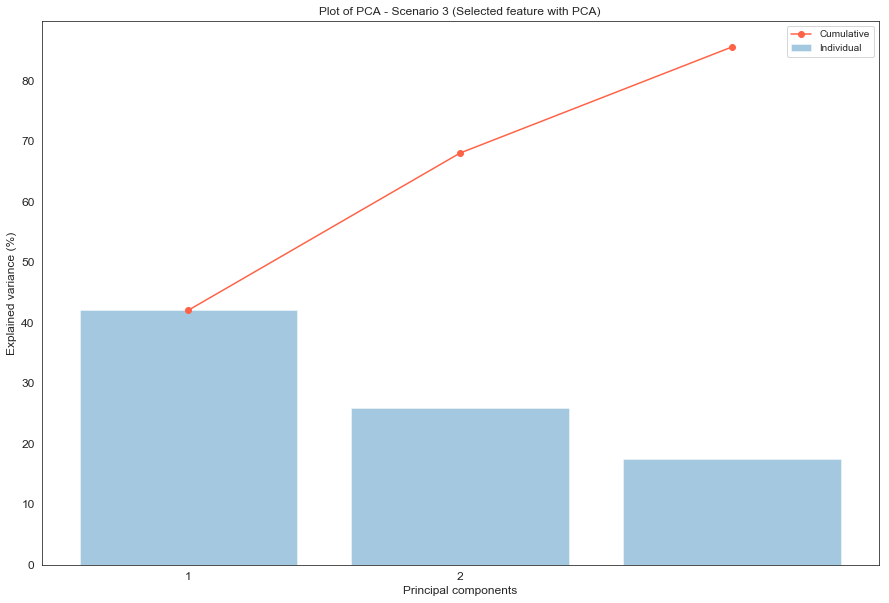

In [41]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(range(len(pca_s3.explained_variance_ratio_)), pca_s3.explained_variance_ratio_, 
        label='Individual', axes=ax, alpha=0.4)
plt.plot(range(len(pca_s3.explained_variance_ratio_)), pca_s3.explained_variance_ratio_.cumsum(), 
         label='Cumulative', color='tomato', axes=ax, marker='o')

ax.set_xticks(range(0,3))
ax.set_xticklabels(range(1,3), fontsize=12)
ax.set_yticklabels(range(0,90,10), fontsize=12)

plt.title('Plot of PCA - Scenario 3 (Selected feature with PCA)', fontsize=12)
plt.ylabel('Explained variance (%)', fontsize=12)
plt.xlabel('Principal components', fontsize=12)
plt.legend()
plt.show()

It can be seen from the above graph that 85% of the variance in data is explained by 3 components.

In [42]:
df_pca_s3 = pd.DataFrame(pca_results_s3)
df_pca_s3.columns = ['PC1', 'PC2','PC3']
df_pca_s3['label'] = kmeanModel_s3.labels_
df_pca_s3.head()

PC1       PC2       PC3  label
0 -1.227655 -1.330071  0.060375      0
1 -0.229915  0.810776  2.296353      1
2 -1.959655 -1.023098 -0.009410      0
3  2.766921 -0.424022 -0.525163      3
4  1.023291 -0.362932 -0.113884      3

**2-D Scatter Plot of Scenario 3**

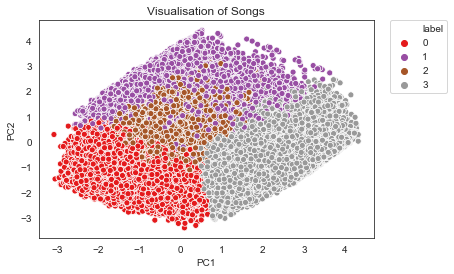

In [43]:
sns.set_style('white')
sns.scatterplot(data=df_pca_s3, x='PC1', y='PC2', hue='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisation of Songs')
plt.show()

It can be seen from the above cluster plot that now the overalp between the grey and red is gone. The cluster seems to be more distinctive now.

**3-D Scatter Plot of Scenario 3**

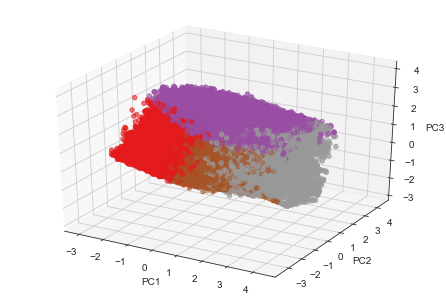

In [44]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca_s3['PC1'], df_pca_s3['PC2'], df_pca_s3['PC3'],
           c=df_pca_s3['label'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

**Song feature distribution compared to overall distribution**

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


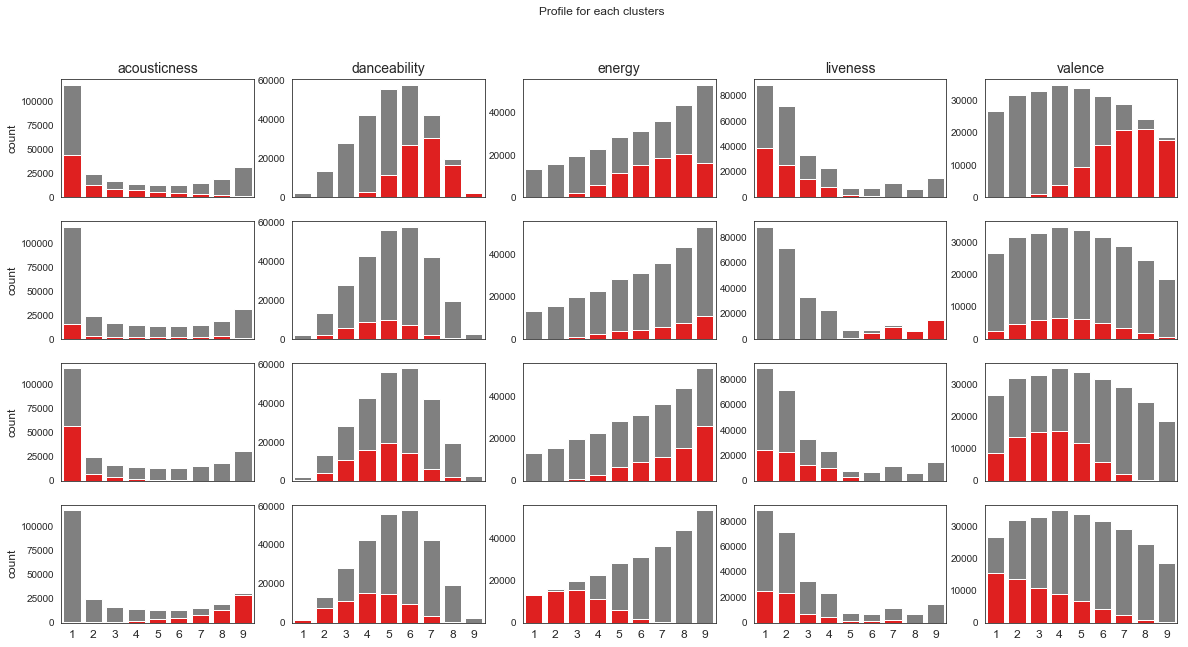

In [45]:
MergedMusic_clean.loc[:,'cluster'] = kmeanModel_s3.labels_
# set binning intervals of 0.1
bins = np.linspace(0,1,10)

# create subplots
num_features = len(cluster_features_selected)
f, axes = plt.subplots(num_clusters, num_features, 
                       figsize=(20, 10), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(MergedMusic_clean['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster_selected_scale = MergedMusic_clean[MergedMusic_clean['cluster'] == cluster]
    col = 0
    
    for feature in cluster_features_selected:
#         create binned count for all recent df and clustered df
        rec_grp = MergedMusic_clean.groupby(pd.cut(MergedMusic_clean[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster_selected_scale.groupby(pd.cut(df_cluster_selected_scale[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='red', ax=axes[row, col])
        
#         configure ax
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(range(1,10), fontsize=12)
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel('count', fontsize=12)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14)        
        col += 1
    row += 1
    
f.suptitle('Profile for each clusters')
    
plt.show()

In the above graph, each row represents the cluster, 0 to 3, and each column represents the feature. The **grey bar** represents the distribution of the feature. This gives a rough idea of the distribution of the feature. The **red bar** represents the distribution of the feature in that cluster which is used to compare against the other clusters.

Looking at the distribution of each cluster, it can be seen that each cluster is high or low in certain features. This is identified by whether the red bar is on the right(high) or left(low) with respect to the grey bar. From these characteristics, songs can be profiled into different themes.

**Interpretation of each feature:**
-	**Acousticness:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is low for cluster 0 and 3 while high for cluster 1. It has no effect on cluster 2.

-	**Danceability:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is high for cluster 0 while in the middle for cluster 1 and 3. It has very little effect on cluster 2.

-	**Energy:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is high for cluster 0 and 1 while low for cluster 1. It has no effect on cluster 2.

-	**Liveness:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is low for cluster 0 and 1. It has no effect on cluster 2 and is distributed across for cluster 3.

-	**Valence:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is high for cluster 0 while low for cluster 1. It has no effect on cluster 2 and is distributed across for cluster 3.

**Average song features per cluster**

In [46]:
# calculate mean of each variable
radar_col_selected_PCA = cluster_features_selected + ['cluster']

# feature average for each cluster as a radar chart
df_radar_selected_PCA = MergedMusic_clean[radar_col_selected_PCA]
df_radar_selected_PCA = df_radar_selected_PCA.groupby('cluster').mean().reset_index()

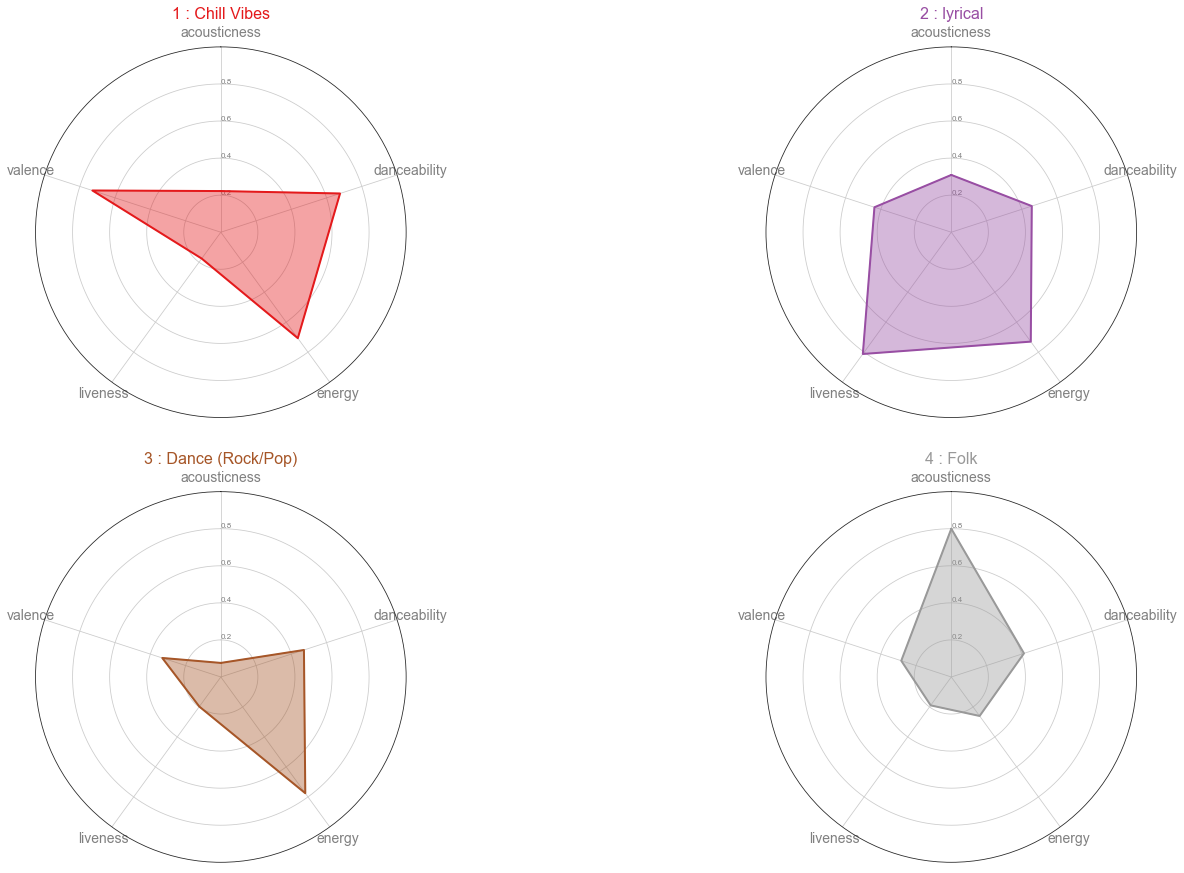

In [47]:
# initialize the figure
plt.figure(figsize=(24,15))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set1", len(df_radar_selected_PCA.index))

# Create cluster name
title_list = ['Chill Vibes', 'lyrical', 'Dance (Rock/Pop)', 'Folk']

# Loop to plot
for row in range(0, len(df_radar_selected_PCA.index)):
    make_radar(row=row, title=str(df_radar_selected_PCA['cluster'][row]+1) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar_selected_PCA, num_clusters=len(df_radar_selected_PCA.index))

title=str(df_radar_selected_PCA['cluster'][row]) + ' : ' + title_list[row],
# Show plot
plt.show()

The readings of the radar chart is similar to the profile given above.

**Interpretation of each Cluster:**

**Cluster 0 (1: Chill Vibes):** 

- **High:** Danceability, Energy, Valence. 

- **Low:** Acousticness, Liveness.


**Cluster 1 (2: Lyrical):** 

- **High:** Loudness, Energy. 

- **Low:** Acousticness, Danceability, Valence.

**Cluster 2 (3: Dance (Rock/Pop)):**

- **High:** Danceability, Energy. 

- **Low:** Acousticness, Liveness, Valence.

**Cluster 3 (4: Folk):**

- **High:** Acousticness. 

- **Low:** Danceability, Energy, Liveness, Valence.

#### Scenario 4: Selected audio features without PCA

In [48]:
#Selected audio features
cluster_features_selected = ['acousticness','danceability','energy','liveness','valence']
df_cluster_selected = MergedMusic_clean[cluster_features_selected]


df_cluster_selected_scale = np.array(df_cluster_selected)
scaler = StandardScaler()
scaler.fit(df_cluster_selected_scale)
df_cluster_selected_scale = scaler.transform(df_cluster_selected_scale)

In [49]:
num_clusters = 4
kmeanModel_s4 = KMeans(n_clusters=num_clusters, max_iter=100, init='k-means++', random_state=123).fit(df_cluster_selected_scale)

**Visualisation of cluster**

Here selected features are considered but without any PCA. THerefore, the PCA is set to 5.

In [50]:
pca_s4 = PCA(n_components=5, random_state=123)
pca_results_s4 = pca_s4.fit_transform(df_cluster_selected_scale)

print(pca_s4.explained_variance_ratio_.sum())
pca_s4.explained_variance_ratio_.cumsum()

df_scree_s4 = pd.DataFrame({'Component': ['1','2','3','4','5'],'Indiv':pca_s4.explained_variance_ratio_})
df_scree_s4['cum_sum'] = df_scree_s4['Indiv'].cumsum()
df_scree_s4

1.0


Component     Indiv   cum_sum
0         1  0.420501  0.420501
1         2  0.259716  0.680217
2         3  0.175126  0.855344
3         4  0.098005  0.953349
4         5  0.046651  1.000000

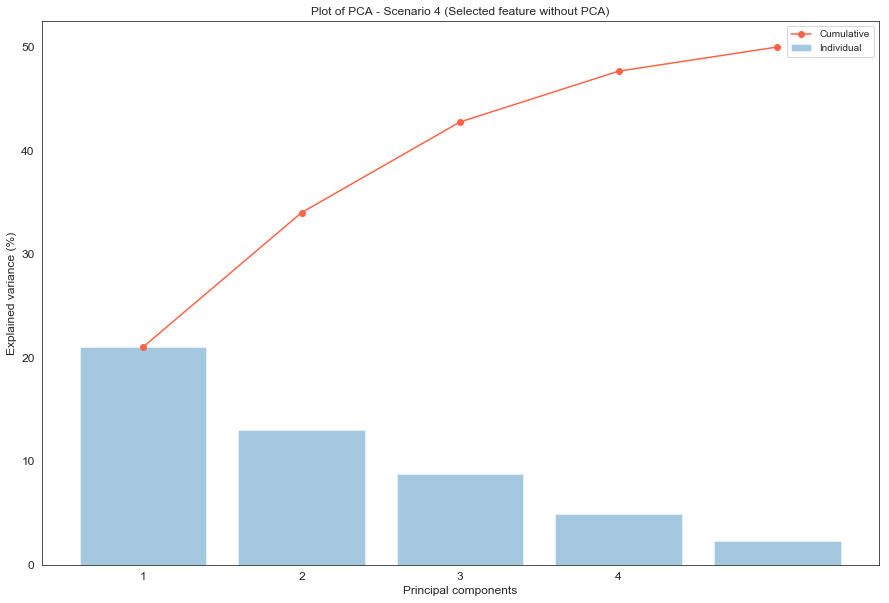

In [51]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(range(len(pca_s4.explained_variance_ratio_)), pca_s4.explained_variance_ratio_, 
        label='Individual', axes=ax, alpha=0.4)
plt.plot(range(len(pca_s4.explained_variance_ratio_)), pca_s4.explained_variance_ratio_.cumsum(), 
         label='Cumulative', color='tomato', axes=ax, marker='o')

ax.set_xticks(range(0,5))
ax.set_xticklabels(range(1,5), fontsize=12)
ax.set_yticklabels(range(0,90,10), fontsize=12)

plt.title('Plot of PCA - Scenario 4 (Selected feature without PCA)', fontsize=12)
plt.ylabel('Explained variance (%)', fontsize=12)
plt.xlabel('Principal components', fontsize=12)
plt.legend()
plt.show()

It can be seen from the above graph that 95% of the variance in data is explained by 4 components.

In [52]:
df_pca_s4 = pd.DataFrame(pca_results_s4)
df_pca_s4.columns = ['PC1', 'PC2','PC3','PC4','PC5']
df_pca_s4['label'] = kmeanModel_s4.labels_
df_pca_s4.head()

PC1       PC2       PC3       PC4       PC5  label
0 -1.227655 -1.330071  0.060375 -0.970012  0.826736      0
1 -0.229915  0.810776  2.296353  0.469003  0.360775      1
2 -1.959655 -1.023098 -0.009410 -0.247989  0.146956      0
3  2.766921 -0.424022 -0.525163 -0.001066 -0.493805      3
4  1.023291 -0.362932 -0.113884  0.773266 -0.491692      3

**2-D Scatter Plot of Scenario 4**

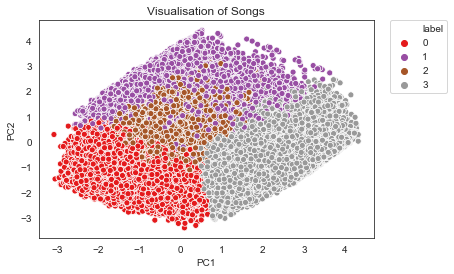

In [53]:
sns.set_style('white')
sns.scatterplot(data=df_pca_s4, x='PC1', y='PC2', hue='label', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisation of Songs')
plt.show()

It can be seen from the above cluster plot that now the overlap between the grey and red is gone. The cluster seems to be more distinctive now.

**3-D Scatter Plot of Scenario 4**

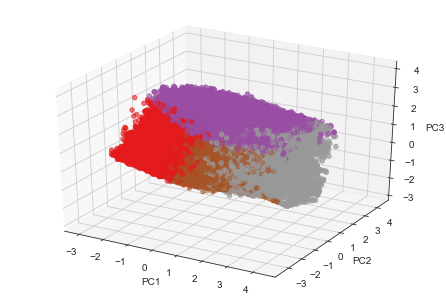

In [54]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca_s4['PC1'], df_pca_s4['PC2'], df_pca_s4['PC3'],
           c=df_pca_s4['label'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

**Song feature distribution compared to overall distribution**

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


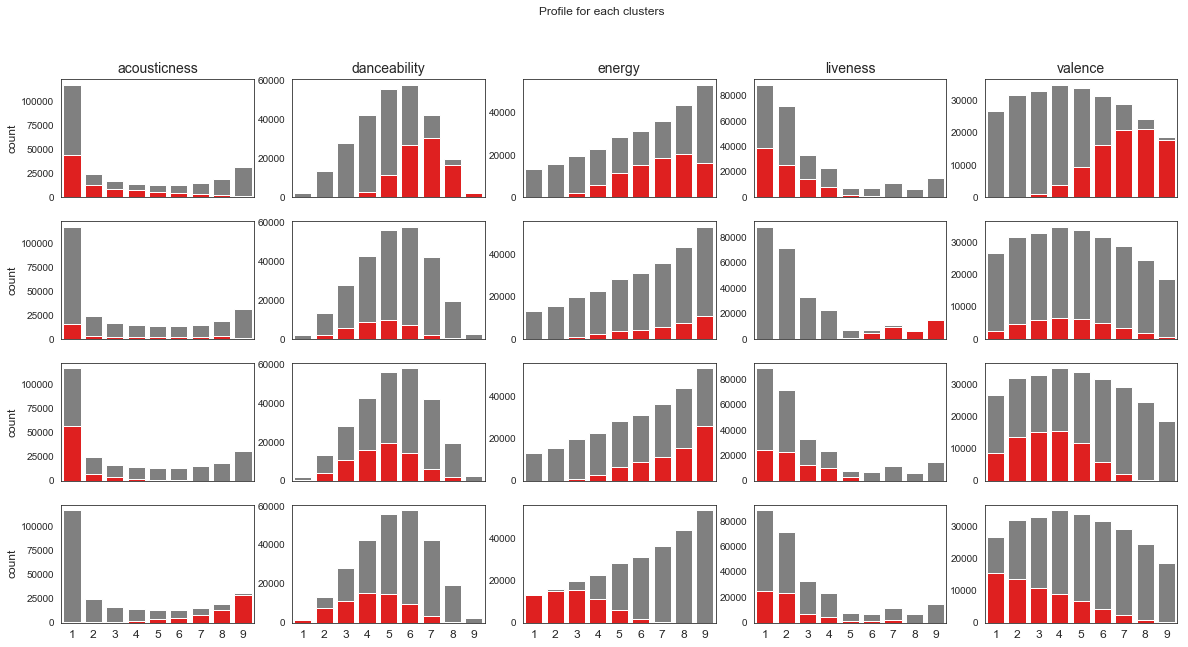

In [55]:
MergedMusic_clean.loc[:,'cluster'] = kmeanModel_s4.labels_
# set binning intervals of 0.1
bins = np.linspace(0,1,10)

# create subplots
num_features = len(cluster_features_selected)
f, axes = plt.subplots(num_clusters, num_features, 
                       figsize=(20, 10), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(MergedMusic_clean['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster_selected_scale = MergedMusic_clean[MergedMusic_clean['cluster'] == cluster]
    col = 0
    
    for feature in cluster_features_selected:
#         create binned count for all recent df and clustered df
        rec_grp = MergedMusic_clean.groupby(pd.cut(MergedMusic_clean[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster_selected_scale.groupby(pd.cut(df_cluster_selected_scale[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='red', ax=axes[row, col])
        
#         configure ax
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(range(1,10), fontsize=12)
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel('count', fontsize=12)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=14)        
        col += 1
    row += 1
    
f.suptitle('Profile for each clusters')
    
plt.show()

In the above graph, each row represents the cluster, 0 to 3, and each column represents the feature. The **grey bar** represents the distribution of the feature. This gives a rough idea of the distribution of the feature. The **red bar** represents the distribution of the feature in that cluster which is used to compare against the other clusters.

Looking at the distribution of each cluster, it can be seen that each cluster is high or low in certain features. This is identified by whether the red bar is on the right(high) or left(low) with respect to the grey bar. From these characteristics, songs can be profiled into different themes.

**Interpretation of each feature:**
-	**Acousticness:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is low for cluster 0 and 3 while high for cluster 1. It has no effect on cluster 2.

-	**Danceability:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is high for cluster 0 while in the middle for cluster 1 and 3. It has very little effect on cluster 2.

-	**Energy:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is high for cluster 0 and 1 while low for cluster 1. It has no effect on cluster 2.

-	**Liveness:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is low for cluster 0 and 1. It has no effect on cluster 2 and is distributed across for cluster 3.

-	**Valence:** This feature is uniquely identifying the clusters as it can be seen from the above graph. It is high for cluster 0 while low for cluster 1. It has no effect on cluster 2 and is distributed across for cluster 3.

**Average song features per cluster**

In [56]:
# calculate mean of each variable
radar_col_selected = cluster_features_selected + ['cluster']

# feature average for each cluster as a radar chart
df_radar_selected = MergedMusic_clean[radar_col_selected]
df_radar_selected = df_radar_selected.groupby('cluster').mean().reset_index()

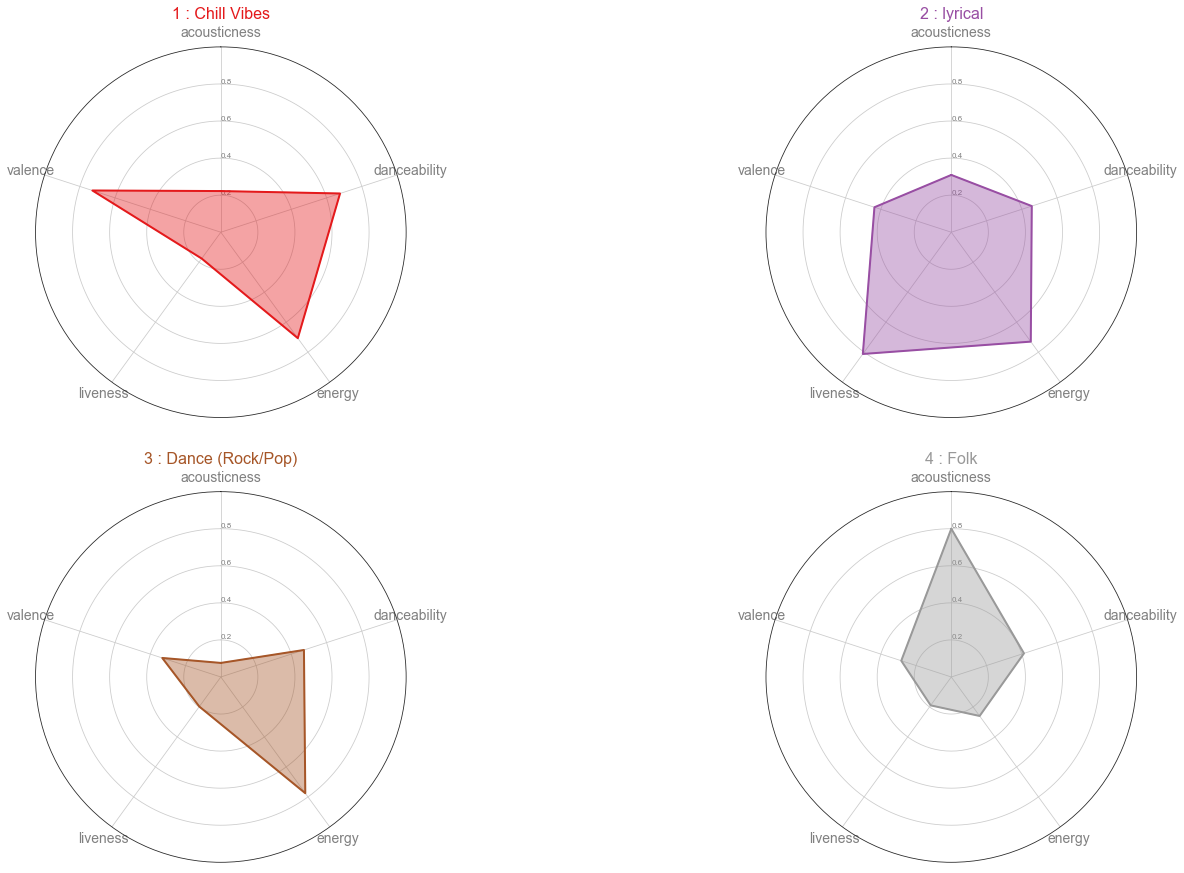

In [57]:
# initialize the figure
plt.figure(figsize=(24,15))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set1", len(df_radar_selected.index))

# Create cluster name
title_list = ['Chill Vibes', 'lyrical', 'Dance (Rock/Pop)', 'Folk']

# Loop to plot
for row in range(0, len(df_radar_selected.index)):
    make_radar(row=row, title=str(df_radar_selected['cluster'][row]+1) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar_selected, num_clusters=len(df_radar_selected.index))

title=str(df_radar_selected['cluster'][row]) + ' : ' + title_list[row],
# Show plot
plt.show()

The readings of the radar chart is similar to the profile given above.

**Interpretation of each Cluster:**

**Cluster 0 (1: Chill Vibes):** 

- **High:** Danceability, Energy, Valence. 

- **Low:** Acousticness, Liveness.


**Cluster 1 (2: Lyrical):** 

- **High:** Loudness, Energy. 

- **Low:** Acousticness, Danceability, Valence.

**Cluster 2 (3: Dance (Rock/Pop)):**

- **High:** Danceability, Energy. 

- **Low:** Acousticness, Liveness, Valence.

**Cluster 3 (4: Folk):**

- **High:** Acousticness. 

- **Low:** Danceability, Energy, Liveness, Valence.

Based on the above four scenarios, the last scenario seems to be giving the most appropriate cluster for the purpose of this project.

### Similarity Calculation

#### Cosine vs Mahalanobis

**Cosine** looks at the angle between vectors. It is generally used when the magnitude of vectors does not matter. For example, if we are taking into the consideration text data for word count.  We can assume when a word(e.g Analytics) occurs more in the first document than it does in second, that document 1 is more related to Analytics. Whereas it could be the case that document 1 is simply bigger than document 2 and so the word is used more times.

**Mahalanobis** distance is a measure of the distance between a point P and a distribution D. It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D.

Mahalanobis distance was used to calculate similarity because it considers variable intercorrelations and weighs each variable equally.

Themes were assigned to each of the songs in the original MergedMusic data and labels were created for the four themes by listening to the songs in each cluster.

In [58]:
#Getting music file with clusters
MergedMusic_clustered = MergedMusic_clean.join(df_pca_s4, how='outer')
MergedMusic_clustered['cluster'] += 1

In [59]:
MergedMusic_clustered.loc[MergedMusic_clustered['label']== 0,['label']] = '1: Chill Vibes'
MergedMusic_clustered.loc[MergedMusic_clustered['label']== 1,['label']] = '2: lyrical'
MergedMusic_clustered.loc[MergedMusic_clustered['label']== 2,['label']] = '3: Dance (Rock/Pop)'
MergedMusic_clustered.loc[MergedMusic_clustered['label']== 3,['label']] = '4: Folk'
MergedMusic_clustered.head()

Index_Id  acousticness                album_id  \
0       0.0        0.1080  67nqYhvjDyJXGD64937Lw3   
1       1.0        0.4250  4S2ZR5njbJez1rV8DV5Vtl   
2       2.0        0.0468  0IyCnBPnQXafGgV0Jsa5Kq   
3       3.0        0.9480  0IyCnBPnQXafGgV0Jsa5Kq   
4       4.0        0.6300  3Fb7L1abcJbTt729nCq2eZ   

                        album_name  \
0  The Beach Boys' Christmas Album   
1                    Live In Japan   
2                 WWE: Uncaged VII   
3                 WWE: Uncaged VII   
4                 Best 1991 - 2004   

                                          artist_ids  \
0  3oDbviiivRWhXwIE8hxkVV,03IJEZ6IynYczgge2uC4YD,...   
1                             7FIoB5PHdrMZVC3q2HE5MS   
2      6irRU9KRGb0cMtlsBZMg2i,0spHbv2fw49lDMkbOAdaqX   
3      6irRU9KRGb0cMtlsBZMg2i,0spHbv2fw49lDMkbOAdaqX   
4                             5GtMEZEeFFsuHY8ad4kOxv   

                                   artist_names  danceability  disc_number  \
0  The Beach Boys,Mark Linett,Sweet,Larry Walsh         0.602          1.0   
1                               George Harrison         0.611          2.0   
2                              Jim Johnston,WWE         0.737          1.0   
3                              Jim Johnston,WWE         0.340          1.0   
4                                          Seal         0.587          1.0   

   duration_ms  energy       ...          tempo  track_number  valence  \
0     118840.0   0.553       ...        130.594           1.0   0.9710   
1     211320.0   0.566       ...        125.240           2.0   0.6390   
2     208573.0   0.801       ...        145.003           4.0   0.8590   
3     230500.0   0.265       ...        110.588           5.0   0.0866   
4     289227.0   0.493       ...        131.727           2.0   0.2100   

   cluster       PC1       PC2       PC3       PC4       PC5           label  
0      1.0 -1.227655 -1.330071  0.060375 -0.970012  0.826736  1: Chill Vibes  
1      2.0 -0.229915  0.810776  2.296353  0.469003  0.360775      2: lyrical  
2      1.0 -1.959655 -1.023098 -0.009410 -0.247989  0.146956  1: Chill Vibes  
3      4.0  2.766921 -0.424022 -0.525163 -0.001066 -0.493805         4: Folk  
4      4.0  1.023291 -0.362932 -0.113884  0.773266 -0.491692         4: Folk  

[5 rows x 29 columns]

In [60]:
df_Music = df_radar_selected

Cluster row was dropped to get a vector of average features per cluster only.

In [153]:
if 'cluster' in df_Music.columns:
    del df_Music['cluster']

df_vector1 below is a list of vector for each cluster.

In [62]:
df_vector1 = df_Music[['acousticness', 'danceability', 'energy', 'liveness', 'valence']].values.tolist()
df_vector1

[[0.22209360102632209,
  0.6764392898809087,
  0.7067909554293547,
  0.1756916809747067,
  0.7287928206652166],
 [0.3091239329703779,
  0.45668186933585597,
  0.7298042382929794,
  0.8121638577032351,
  0.4360640411199802],
 [0.07586645260018812,
  0.47160901662863935,
  0.7754011641411779,
  0.19738608427726448,
  0.3322142009919812],
 [0.8000029329398459,
  0.4123926749754262,
  0.26002409006691646,
  0.18938130059741776,
  0.2838844321390122]]

Mahalanobis requires the inverse covrance of the vector to be calculated.

In [63]:
#Calculate covariance matrix
covmx = df_Music.cov()
invcovmx = sp.linalg.inv(covmx)

**Training and Testing set**

User music data was split randomly between the training (70%) and test (30%) set for each user.

In [64]:
#importing user data
UserMusic_Train = pd.read_csv(r'UserMusic_Train.csv', encoding='ISO-8859-1')
UserMusic_Test = pd.read_csv(r'UserMusic_Test.csv', encoding='ISO-8859-1')

In [65]:
UserMusic_Train.head(2)

Index  id  danceability  energy  key  loudness  mode  speechiness  \
0     81  81         0.626   0.249   11   -15.410     1       0.0279   
1      9   9         0.569   0.761    5    -6.071     0       0.4750   

   acousticness  instrumentalness  ...    valence    tempo  user_session  \
0         0.752          0.000313  ...      0.322   83.022             2   
1         0.261          0.000007  ...      0.325  180.122             1   

   user_response  user_id               database_id    alpha cluster  \
0              0        1  5bb7ac8b0c27ee4c381dd748  alpha50       3   
1              0        1  5bb7ac910c27ee4c381dd90a  alpha50       3   

   Randomness  Rand2  
0           1     28  
1           0     29  

[2 rows x 21 columns]

In [66]:
UserMusic = UserMusic_Train[['acousticness', 'danceability', 'energy', 'liveness', 'valence']]

In [67]:
UserMusic_Train['cluster'] = np.nan

In [68]:
df_vector3 = UserMusic[['acousticness', 'danceability', 'energy', 'liveness', 'valence']].values.tolist()

We picked a song from user data and used Mahalanobis to find the theme closest to a particular song.

In [69]:
list11=[]
for j in range(len(df_vector3)):
    for i in range(4):
        list11.append(mahalanobis(df_vector1[i], df_vector3[j], invcovmx))
    list11.index(min(list11))
    UserMusic_Train['cluster'].iloc[j] = list11.index(min(list11)) + 1
    list11=[]

D:\Users\chandu-user\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [70]:
print(UserMusic_Train.head())

   Index  id  danceability  energy  key  loudness  mode  speechiness  \
0     81  81         0.626   0.249   11   -15.410     1       0.0279   
1      9   9         0.569   0.761    5    -6.071     0       0.4750   
2     11  11         0.392   0.936    5    -6.532     1       0.0849   
3     67  67         0.841   0.933    0    -3.385     1       0.1680   
4     71  71         0.788   0.733   11    -8.433     0       0.0519   

   acousticness  instrumentalness  ...    valence    tempo  user_session  \
0      0.752000          0.000313  ...      0.322   83.022             2   
1      0.261000          0.000007  ...      0.325  180.122             1   
2      0.000221          0.839000  ...      0.564  167.333             1   
3      0.006050          0.815000  ...      0.361  128.013             2   
4      0.000754          0.882000  ...      0.800  134.023             2   

   user_response  user_id               database_id    alpha cluster  \
0              0        1  5bb7ac8b0c2

### Theme Probability

We calculated the probability of a particular user liking a theme. This was calculated by dividing the number of liked songs by the total number of songs a user has listend to in a particular theme.

In [71]:
UserMusicGrouped_train = pd.DataFrame(UserMusic_Train.groupby(['user_id','cluster','user_response'], as_index = False)['id'].count())

UserMusicGrouped2_train = pd.DataFrame(UserMusic_Train.groupby(['user_id','cluster',], as_index = False)['id'].count())

print(UserMusicGrouped_train.head())

   user_id  cluster  user_response  id
0        1      1.0              0  19
1        1      1.0              1   4
2        1      2.0              0   1
3        1      2.0              1   3
4        1      3.0              0  19


In [72]:
prob = []
for i in range(30):
    for j in range(4):
        t1 =(UserMusicGrouped_train[(UserMusicGrouped_train['user_id'] == (i+1)) & (UserMusicGrouped_train['cluster'] == (j+1)) & (UserMusicGrouped_train['user_response'] == 1)]['id']).values
        t2 = (UserMusicGrouped_train[(UserMusicGrouped_train['user_id'] == (i+1)) & (UserMusicGrouped_train['cluster'] == (j+1)) & (UserMusicGrouped_train['user_response'] == 0)]['id']).values

        prob = (np.around((t1/(t1+t2)), decimals = 2))
        
        if len(prob)>0:
            prob[0] = prob[0]
        else:
            prob = [0]
            
        UserMusicGrouped2_train['id'] = UserMusicGrouped2_train['id'].astype(object)
        UserMusicGrouped2_train.loc[(UserMusicGrouped2_train['user_id'] == (i+1)) & (UserMusicGrouped2_train['cluster'] == (j+1)), ['id']]= prob[0]
        
        t1 = 0
        t2 = 0
        
UserMusicGrouped2_train.head()

user_id  cluster    id
0        1      1.0  0.17
1        1      2.0  0.75
2        1      3.0  0.24
3        1      4.0  0.12
4        2      1.0  0.58

### Model Accuracy

The objective of any recommendar system is to be as accurate as possible when recommending a song to a user. Here the objective was to see how good our recommender will perform to the unseen data.

In [73]:
UserMusic_Test['predicted_response'] = np.nan

In [74]:
for i in range(1,len(UserMusic_Test['user_id'])):
    if (UserMusicGrouped2_train[(UserMusicGrouped2_train['user_id'] == UserMusic_Test.iloc[i]['user_id']) &
                                (UserMusicGrouped2_train['cluster'] == UserMusic_Test.iloc[i]['cluster'])]['id']).values > 0.5: 
            #UserMusic_Test.iloc[i]['predicted_response'] = 1
            UserMusic_Test.loc[i,'predicted_response'] = 1
    else: 
            UserMusic_Test.loc[i,'predicted_response'] = 0

In [75]:
UserMusic_Test.head()

Index  id  danceability  energy  key  loudness  mode  speechiness  \
0     32  32         0.890   0.791    0    -4.761     1       0.2090   
1     46  46         0.504   0.919    8    -1.433     1       0.1160   
2     56  56         0.708   0.687    7    -6.086     1       0.0324   
3     43  43         0.498   0.242    9   -12.238     1       0.0257   
4     55  55         0.611   0.697    2    -8.618     1       0.1330   

   acousticness  instrumentalness         ...            tempo  user_session  \
0        0.2290             0.000         ...          101.964             1   
1        0.3190             0.000         ...          108.092             2   
2        0.2710             0.000         ...           89.985             2   
3        0.8350             0.536         ...          153.744             2   
4        0.0193             0.000         ...          122.752             2   

   user_response  user_id               database_id    alpha cluster  \
0              0        1  5bb7ac8c0c27ee4c381dd7a3  alpha50       1   
1              0        1  5bb7ac920c27ee4c381dd97e  alpha50       3   
2              0        1  5bb7ac930c27ee4c381dd9d9  alpha50       1   
3              0        1  5bb7ac890c27ee4c381dd6a7  alpha50       4   
4              0        1  5bb7ac8c0c27ee4c381dd79c  alpha50       4   

  Randomness  Rand2  predicted_response  
0          0      0                 NaN  
1          1      0                 0.0  
2          1      0                 0.0  
3          1      1                 0.0  
4          1      1                 0.0  

[5 rows x 22 columns]

In [76]:
Total_Test = len(UserMusic_Test['user_id'])
Correct_Prediction = 0
for i in range(1,len(UserMusic_Test['user_id'])):
    if UserMusic_Test.loc[i,'predicted_response'] == UserMusic_Test.loc[i,'user_response']:
        Correct_Prediction = Correct_Prediction + 1
    else:
        Correct_Prediction = Correct_Prediction + 0 

Accuracy = (Correct_Prediction/Total_Test)*100
print("The accuracy of the recommender system is " + repr(str(round(Accuracy, 2))) + "%.")

The accuracy of the recommender system is '73.59'%.


It can be seen from above that our personalised recommender system's accracy is about 74%. This is not a bad for a baisc recommender system. This recommender system can be further improved by adding user based recommendation as an add-on.

### Recommender

The recommender system can let the audience know whether a particular song should be recommended to a user based on their taste. Secondly, it also provided top 5 songs to a user from a particular theme.

**Recommendation by Song**

In [78]:
while True:
    try:
        User_ID = int(input('Please enter an user id:'))
        break
    except:
        print("Please enter a whole number!")

while True:
    try:
        Song_name = input('Please enter a song name:')
        break
    except:
        print("Please enter a valid id!")
        
Cluster_ID = (MergedMusic_clustered[MergedMusic_clustered['song_name'] == Song_name]['cluster']).values

if (UserMusicGrouped2_train[(UserMusicGrouped2_train['user_id'] == User_ID) & (UserMusicGrouped2_train['cluster'] == Cluster_ID[0])]['id']).values > 0.5:
    print('This song is recommended!')
else:
    print('This song is not recommended!')
#Beware the Bull (1991)

Please enter an user id:1
Please enter a song name:Beware the Bull (1991)
This song is not recommended!


**Recommendation by Theme**

In [86]:
while True:
    try:
        User_ID = int(input('Please enter an user id:'))
        break
    except:
        print("Please enter a whole number!")

while True:
    try:
        Theme_name = input('Please enter a Theme:')
        break
    except:
        print("Please enter a valid id!")
        

#1: Chill Vibes (use this value as an example)
Top5songs = pd.DataFrame(MergedMusic_clustered[MergedMusic_clustered["label"]==Theme_name].nlargest(5, "popularity")["song_name"])
print("Top 5 songs in " + Theme_name + " for user " + repr(str(User_ID)) +":")
print(Top5songs)Conclusion:

- For supervised Learning objective, predicting the popularity of a song based on it audio features, Random forest has outperformed all the other models.
- For unsupervised learning, our personalized recommender system, was able to predict whether a particular song or theme is recommended for the user or not, based on his/her liking.

Please enter an user id:1
Please enter a Theme:1: Chill Vibes
Top 5 songs in 1: Chill Vibes for user '1':
                                      song_name
102866                                     2002
74463                                      1999
102865                                     2002
217201                           No Role Modelz
207641  Hotel California - Eagles 2013 Remaster


# Conclusion:

- For supervised Learning objective, predicting the popularity of a song based on its audio features, Random forest has outperformed all the other models.
- For unsupervised learning, our personalized recommender system, was able to predict whether a particular song or theme is recommended for the user or not, based on his/her liking.



# Insights

### Supervised Learning:
- We observed that model tunning, through GridSearchCV and RandomizedSearcgCV did not significantly improve the accuracy score in most of the machine learning algorithms which we have used for our data. 
- RamdomizedsearchCV was computationally very expensive for Random Forest, SVM and KNN. 
- F1 score in each model was higher for class 0 (flop) and compared to class 1 (hit) due to class imbalance. However, the imbalance was not large enough to justify the use of techniques such as undersampling, oversampling, data generation using SMOTE etc.

### Unsupervised learning: 
- Using different models and techniques, we realized that the songs can be uniquely classified in four clusters. 
- Mahalanobis Distance is the most accurate measure, for our case, to calculate similarity of correlated features